# **Classifying Images Using MLP and SVM Algorithms**
This notebook is to explore the concepts of training and evaluating classifiers such as the Multi-layer Perceptron (MLP) and Support Vector Machines (SVM) using the CIFAR-10 Data set.  




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# uncomment the below to mount the google drive
#from google.colab import drive
#drive.mount('/content/drive')

## Functions to work with CIFAR

The functions below help with access to the CIFAR-10 data

In [ ]:
import pickle
import numpy as np
import pandas as pd

def load_CIFAR_batch(filename, flatten=True, categorical=True):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        if (flatten):
          X = X.reshape(10000, 3072)
        X = X.astype('float32')
        X /= 255

        y = datadict[b'labels']
        y = np.array(y)
        if (categorical):
          y = pd.get_dummies(y).values

        return X, y

def load_CIFAR_meta(filename):
  with open(filename,'rb') as f:
    metadict = pickle.load(f, encoding='bytes')

    class_labels = [ val.decode() for val in metadict.get(b'label_names') ]
    return class_labels

def get_image(X, index, nchans=3, size=32):
  xi = X[index,:]
  img = xi.reshape(32, 32, 3)
  return img

## Load the CIFAR data

The CIFAR data has 5 batches of data and 1 test data set. Each batch is labelled
- `data_batch_1`
- `data_batch_2`
- `data_batch_3`
- `data_batch_4`
- `data_batch_5`

and a test set labelled
- `test_batch`

each batch has 10,000 images, so 50,000 training and 10,000 test images.

Below is example of loading the first batch of training data labelled as `data_batch_1`.  

In [ ]:
X, y = load_CIFAR_batch('/content/drive/My Drive/cifar-10-batches-py/data_batch_2')

**SPLIT THE DATA INTO TRAIN AND TEST**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

***NOMALIZE THE DATA USING Z-SCORE STANDARD SCALER***

In [ ]:
# Initialize the StandardScaler I AM USING Z-Score STANDARDIZATION
scaler = StandardScaler()

#transform training data
Xtrain_scaled = scaler.fit_transform(Xtrain)

#transform testing data
Xtest_scaled = scaler.transform(Xtest)

**PCA INVESTIGATION**

Explained Variance Ratios: [2.7043769e-01 1.1415476e-01 7.1536444e-02 ... 3.4262699e-09 3.3321039e-09
 3.1467868e-09]


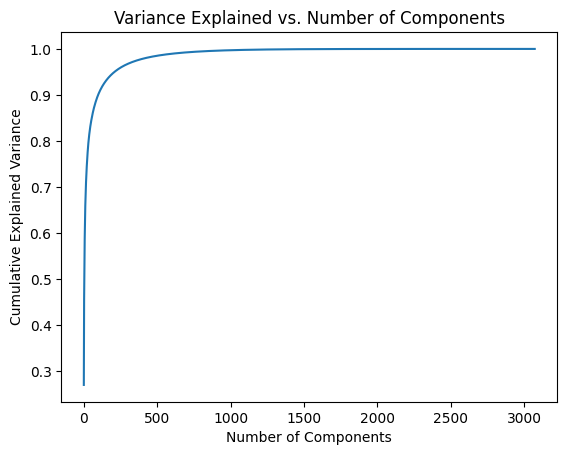

Number of components for 99% explained variance: 613
Number of components for 95% explained variance: 209


In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA with desired number of components
n_components = 3072
pca = PCA(n_components=n_components)

# Apply PCA to scaled data
Xtrain_pca = pca.fit_transform(Xtrain_scaled)
Xtest_pca = pca.transform(Xtest_scaled)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)

import matplotlib.pyplot as plt

cum_explained_variance = np.cumsum(explained_variance)
plt.plot(cum_explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Variance Explained vs. Number of Components")
plt.show()

index_99_percent = np.argmax(cum_explained_variance >= 0.99) #Explained Variance Calculations (VALUES CHANGE ON EACH REFRESH SLIGHTLY!)
index_95_percent = np.argmax(cum_explained_variance >= 0.95)

# Print the number of components for 99% and 95% explained variance
print(f"Number of components for 99% explained variance: {index_99_percent}")
print(f"Number of components for 95% explained variance: {index_95_percent}")

***SET PCA TO DESIRED COMPONENTS***

In [ ]:
n_components = 209 #CHOOSEN FROM EXPLAINED VARIANCE 95%
pca = PCA(n_components=n_components)

# Apply PCA to scaled data
Xtrain_pca = pca.fit_transform(Xtrain_scaled)
Xtest_pca = pca.transform(Xtest_scaled)

***TRAINED THE MLP *************

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

hidden_layer_sizes = 1050
activation_fcn = 'relu'  # {identity, logistic, tanh, relu}, default='relu'
max_iter = 10

# model initialization
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes), activation=activation_fcn,
                    max_iter=max_iter,
                    solver='adam', verbose=1,
                    random_state=None,
                    tol=0.00001, n_iter_no_change=20)

mlp.fit(Xtrain_pca, ytrain)

# Evaluate performance on validation set
validation_accuracy = mlp.score(Xtest_pca, ytest)

# Evaluate performance on training set
training_accuracy = mlp.score(Xtrain_pca, ytrain)
#Evaluation of MLP
ytrue = np.argmax(ytest, axis=1)

#prediction prob
ypreda = mlp.predict_proba(Xtest_pca)

#prediction labels
ypred = np.argmax(ypreda, axis=1)

#classification report
report = classification_report(ytrue, ypred)

#confusion matrix
mat = confusion_matrix(ytrue, ypred)

print(f"Training Accuracy: {training_accuracy}")
print(f"Validation Accuracy: {validation_accuracy}")
print("Classification Report from test set:")
print(report)

print("\nConfusion Matrix:")
print(mat)

Iteration 1, loss = 3.59468874
Iteration 2, loss = 2.25943474
Iteration 3, loss = 1.91739232
Iteration 4, loss = 1.68428926
Iteration 5, loss = 1.49058922
Iteration 6, loss = 1.32129674
Iteration 7, loss = 1.18259209
Iteration 8, loss = 1.04628036
Iteration 9, loss = 0.92614217
Iteration 10, loss = 0.81560194
Training Accuracy: 0.8556
Validation Accuracy: 0.2628
Classification Report from test set:
              precision    recall  f1-score   support

           0       0.51      0.50      0.51       251
           1       0.51      0.50      0.51       244
           2       0.36      0.35      0.35       258
           3       0.29      0.22      0.25       254
           4       0.38      0.33      0.35       250
           5       0.30      0.32      0.31       234
           6       0.42      0.48      0.45       258
           7       0.48      0.49      0.49       250
           8       0.52      0.59      0.55       256
           9       0.50      0.51      0.51       245

  

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


**Testing different activation functions**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import time

activation_functions = ['relu', 'tanh', 'logistic','identity']

for activation in activation_functions:
    start_time = time.time()  # Record the start time

    mlp = MLPClassifier(hidden_layer_sizes=(500,), activation=activation, max_iter=50, solver='adam', random_state=None)
    mlp.fit(Xtrain_pca, ytrain)

    end_time = time.time()  # Record the end time

    # Calculate the training time
    training_time = end_time - start_time

    # Evaluate performance on validation set
    validation_accuracy = mlp.score(Xtest_pca, ytest)

    # Evaluate performance on training set
    training_accuracy = mlp.score(Xtrain_pca, ytrain)

    # Evaluation of MLP on test set
    ytrue = np.argmax(ytest, axis=1)

    # Prediction prob
    ypreda = mlp.predict_proba(Xtest_pca)

    # Prediction labels
    ypred = np.argmax(ypreda, axis=1)

    # Classification report
    report = classification_report(ytrue, ypred)

    print(f"Activation Function: {activation}")
    print(f"Training Time: {training_time:.2f} seconds")  # Print the training time
    print(f"Training Accuracy: {training_accuracy}")
    print(f"Validation Accuracy: {validation_accuracy}")
    print("Classification Report:")
    print(report)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Activation Function: relu
Training Time: 19.93 seconds
Training Accuracy: 1.0
Validation Accuracy: 0.2888
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.50      0.49       251
           1       0.50      0.44      0.47       244
           2       0.38      0.38      0.38       258
           3       0.29      0.30      0.30       254
           4       0.38      0.38      0.38       250
           5       0.32      0.31      0.32       234
           6       0.47      0.50      0.49       258
           7       0.53      0.50      0.51       250
           8       0.57      0.61      0.59       256
           9       0.48      0.49      0.48       245

    accuracy                           0.44      2500
   macro avg       0.44      0.44      0.44      2500
weighted avg       0.44      0.44      0.44      2500



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Activation Function: tanh
Training Time: 11.94 seconds
Training Accuracy: 0.9994666666666666
Validation Accuracy: 0.2052
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.42      0.44       251
           1       0.48      0.45      0.46       244
           2       0.29      0.28      0.28       258
           3       0.21      0.18      0.19       254
           4       0.30      0.37      0.33       250
           5       0.30      0.23      0.26       234
           6       0.38      0.49      0.43       258
           7       0.44      0.40      0.42       250
           8       0.47      0.57      0.51       256
           9       0.46      0.42      0.44       245

    accuracy                           0.38      2500
   macro avg       0.38      0.38      0.38      2500
weighted avg       0.38      0.38      0.38      2500



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Activation Function: logistic
Training Time: 11.08 seconds
Training Accuracy: 0.9062666666666667
Validation Accuracy: 0.2188
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.45      0.44       251
           1       0.54      0.49      0.51       244
           2       0.37      0.39      0.38       258
           3       0.30      0.24      0.27       254
           4       0.40      0.37      0.39       250
           5       0.34      0.28      0.31       234
           6       0.42      0.55      0.48       258
           7       0.48      0.45      0.46       250
           8       0.44      0.56      0.49       256
           9       0.51      0.47      0.49       245

    accuracy                           0.43      2500
   macro avg       0.42      0.43      0.42      2500
weighted avg       0.42      0.43      0.42      2500

Activation Function: identity
Training Time: 3.82 seconds
Training Accuracy: 0.18066666666666

***GRID SEARCH FOR MLP PARAMS***

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(400,), (500,), (1000,)],
    'activation': ['relu','logistic'],
    'max_iter': [10, 50, 100]
}

grid_search = GridSearchCV(MLPClassifier(solver='adam', random_state=None, tol=0.00001, n_iter_no_change=20),
                           param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(Xtrain_pca, ytrain)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


# Evaluate performance on validation set
validation_accuracy = best_model.score(Xtest_pca, ytest)

# Evaluate performance on training set
training_accuracy = best_model.score(Xtrain_pca, ytrain)

# Evaluation of MLP on test set
ytrue = np.argmax(ytest, axis=1)

# Prediction prob
ypreda = best_model.predict_proba(Xtest_pca)

# Prediction labels
ypred = np.argmax(ypreda, axis=1)

# Classification report
report = classification_report(ytrue, ypred)

# Confusion matrix
mat = confusion_matrix(ytrue, ypred)

print(f"Best Hyperparameters: {best_params}")
print(f"Training Accuracy: {training_accuracy}")
print(f"Validation Accuracy: {validation_accuracy}")
print("Classification Report from test set:")
print(report)
print("\nConfusion Matrix:")
print(mat)

# Evaluate best model on test set
test_accuracy = best_model.score(Xtest_pca, ytest)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Hyperparameters: {'activation': 'relu', 'hidden_layer_sizes': (1000,), 'max_iter': 100}
Training Accuracy: 1.0
Validation Accuracy: 0.292
Classification Report from test set:
              precision    recall  f1-score   support

           0       0.50      0.49      0.49       251
           1       0.56      0.52      0.54       244
           2       0.38      0.41      0.40       258
           3       0.30      0.31      0.31       254
           4       0.41      0.40      0.41       250
           5       0.37      0.29      0.33       234
           6       0.49      0.54      0.52       258
           7       0.53      0.52      0.52       250
           8       0.57      0.63      0.60       256
           9       0.49      0.48      0.48       245

    accuracy                           0.46      2500
   macro avg       0.46      0.46      0.46      2500
weighted avg       0.46      0.46      0.46      2500


Confusion Matrix:
[[122  10  21  13   8   5   5  12  43  12]

**Initializing and train SVM**

In [ ]:
import numpy as np
from sklearn.svm import SVC

ytrain_labels = np.argmax(ytrain, axis=1)
ytest_labels = np.argmax(ytest, axis=1)

# Initialize SVM
svm = SVC(kernel='rbf', C=10.0, gamma='scale', verbose=True, random_state=None)

# Train the SVM
svm.fit(Xtrain_pca, ytrain_labels)

svm_test_accuracy = svm.score(Xtest_pca, ytest_labels)
print(f"SVM Test Set Accuracy: {svm_test_accuracy}")


[LibSVM]SVM Test Set Accuracy: 0.4664


**CROSS VALIDATION FOR SVM USING GRID SEARCH(prints each params score)**

The SVM uses Grid Search in a way that prints the results fro each parameter set tested vis nested forloop printing the best overall param settings at the end

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

ytrain_labels = np.argmax(ytrain, axis=1)
ytest_labels = np.argmax(ytest, axis=1)

# Define the parameter grid for SVM
svm_param_grid = {
    'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'kernel': ['rbf']
}

# Initialize GridSearchCV with SVM classifier and parameter grid
svm_grid_search = GridSearchCV(SVC(random_state=None), svm_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Store results
results = []

# Perform nested cross-validation for SVM
for C in svm_param_grid['C']:
    for kernel in svm_param_grid['kernel']:
        print(f"Current Parameters: C={C}, kernel={kernel}")

        # Update the parameter values
        svm_grid_search.param_grid = {'C': [C], 'kernel': [kernel]}

        # Record start time
        start_time = time.time()

        # Fit the model
        svm_grid_search.fit(Xtrain_pca, ytrain_labels)

        # Get the best SVM model
        best_svm_model = svm_grid_search.best_estimator_

        # Evaluate the best SVM model on the test set
        best_svm_test_accuracy = best_svm_model.score(Xtest_pca, ytest_labels)

        # Record end time
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Store results
        results.append({
            'C': C,
            'kernel': kernel,
            'best_params': svm_grid_search.best_params_,
            'cross_val_score': svm_grid_search.best_score_,
            'test_accuracy': best_svm_test_accuracy,
            'training_time': elapsed_time
        })

best_params = None
best_accuracy = 0

# Print results
for result in results:
    print(f"Parameters: C={result['C']}, kernel={result['kernel']}")
    print(f"Best SVM Hyperparameters: {result['best_params']}")
    print(f"Best SVM Cross-Validation Score: {result['cross_val_score']}")
    print(f"SVM Test Set Accuracy: {result['test_accuracy']}")
    print(f"Training Time: {result['training_time']} seconds")
    print("="*30)

    # Update best parameters if needed
    if result['test_accuracy'] > best_accuracy:
        best_accuracy = result['test_accuracy']
        best_params = result['best_params']

# Print the best parameters
print(f"\nBest Parameters:")
print(f"Best SVM Hyperparameters: {best_params}")
print(f"Best SVM Test Set Accuracy: {best_accuracy}")

Current Parameters: C=10000, kernel=rbf
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Current Parameters: C=1000, kernel=rbf
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Current Parameters: C=100, kernel=rbf
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Current Parameters: C=10, kernel=rbf
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Current Parameters: C=1, kernel=rbf
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Current Parameters: C=0.1, kernel=rbf
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Current Parameters: C=0.01, kernel=rbf
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Current Parameters: C=0.001, kernel=rbf
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Current Parameters: C=0.0001, kernel=rbf
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Current Parameters: C=1e-05, kernel=rbf
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Parameters: C=10000, k

**10X10 Cross Validation MLP Model (Structured was used from last prac)**

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

n_outer =  10 # this should be 10 for the "10"x 10 CV, you could use a smaller values, say 2, for prototyping
n_splits = 10 # this should be 10 for the 10 x "10" CV, you could use a smaller values, say 2, for prototyping
acc_outer_svm = []
f1_outer_svm  = []
mcc_outer_svm  = []

hidden_layer_sizes = 500
activation_fcn = 'logistic'  #change params to test top params
max_iter = 50

for i_outer in range(0,n_outer):

  print('#### Outer Iteration {} of {}'.format(i_outer+1,n_outer))

  # shuffle the dataset every time we do the 10 CV (we really want to be random)
  X_shuf, y_shuf = shuffle(Xtrain_pca, ytrain_labels)

  # create a pipeline classifier model based on the best parameters (USE BEST PARAMS FROM GRID SEARCH)
  model = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes), activation=activation_fcn,
                    max_iter=max_iter,
                    solver='adam', verbose=1,
                    random_state=None,
                    tol=0.00001, n_iter_no_change=20)

  # stratification is always a must!
  skf = StratifiedKFold(n_splits=n_splits,shuffle=True) # inner 10

  # cross_val_predict returns the predictions for the folds
  print('***** cross_val_predict')
  y_pred = cross_val_predict(model, X_shuf, y_shuf, cv=skf, verbose=0)

  acc = accuracy_score(y_shuf,y_pred)
  f1 = f1_score(y_shuf,y_pred,average='macro')
  mcc = matthews_corrcoef(y_shuf,y_pred)
  mat = confusion_matrix(y_shuf, y_pred)

  acc_outer_svm.append(acc)
  f1_outer_svm.append(f1)
  mcc_outer_svm.append(mcc)

print('SVM Outer accuracy M = {:.2f}, SD = {:.4f}'.format(np.mean(acc_outer_svm)*100,np.std(acc_outer_svm)*100))
print('SVM Outer F1-Score M = {:.3f}, SD = {:.4f}'.format(np.mean(f1_outer_svm),np.std(f1_outer_svm)))
print('SVM Outer MCC      M = {:.3f}, SD = {:.4f}'.format(np.mean(mcc_outer_svm),np.std(mcc_outer_svm)))


#### Outer Iteration 1 of 10
***** cross_val_predict
Iteration 1, loss = 2.01195790
Iteration 2, loss = 1.71219437
Iteration 3, loss = 1.61922513
Iteration 4, loss = 1.56434171
Iteration 5, loss = 1.52070616
Iteration 6, loss = 1.48423793
Iteration 7, loss = 1.45061422
Iteration 8, loss = 1.42407242
Iteration 9, loss = 1.38644210
Iteration 10, loss = 1.35403016
Iteration 11, loss = 1.31916276
Iteration 12, loss = 1.28785376
Iteration 13, loss = 1.25186898
Iteration 14, loss = 1.21127233
Iteration 15, loss = 1.17189349
Iteration 16, loss = 1.13806542
Iteration 17, loss = 1.09294577
Iteration 18, loss = 1.05536279
Iteration 19, loss = 1.01041478
Iteration 20, loss = 0.96627229
Iteration 21, loss = 0.92421850
Iteration 22, loss = 0.88271154
Iteration 23, loss = 0.83871333
Iteration 24, loss = 0.79919868
Iteration 25, loss = 0.75441507
Iteration 26, loss = 0.71757594
Iteration 27, loss = 0.68034274
Iteration 28, loss = 0.63947409
Iteration 29, loss = 0.60066514
Iteration 30, loss = 0.56712

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01736807
Iteration 2, loss = 1.71608758
Iteration 3, loss = 1.62025273
Iteration 4, loss = 1.56626975
Iteration 5, loss = 1.52165812
Iteration 6, loss = 1.49258202
Iteration 7, loss = 1.45580726
Iteration 8, loss = 1.42465779
Iteration 9, loss = 1.39054089
Iteration 10, loss = 1.36384691
Iteration 11, loss = 1.32846663
Iteration 12, loss = 1.29336499
Iteration 13, loss = 1.25597276
Iteration 14, loss = 1.22216387
Iteration 15, loss = 1.18685374
Iteration 16, loss = 1.14340191
Iteration 17, loss = 1.10476533
Iteration 18, loss = 1.06145321
Iteration 19, loss = 1.02742732
Iteration 20, loss = 0.98328909
Iteration 21, loss = 0.93869234
Iteration 22, loss = 0.89543389
Iteration 23, loss = 0.85212828
Iteration 24, loss = 0.81311305
Iteration 25, loss = 0.77291265
Iteration 26, loss = 0.73312492
Iteration 27, loss = 0.69045222
Iteration 28, loss = 0.65389566
Iteration 29, loss = 0.61378342
Iteration 30, loss = 0.57719905
Iteration 31, loss = 0.54194658
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01594461
Iteration 2, loss = 1.71154793
Iteration 3, loss = 1.61906475
Iteration 4, loss = 1.56293077
Iteration 5, loss = 1.51840959
Iteration 6, loss = 1.48519977
Iteration 7, loss = 1.45445288
Iteration 8, loss = 1.41886632
Iteration 9, loss = 1.38850196
Iteration 10, loss = 1.35419158
Iteration 11, loss = 1.32439683
Iteration 12, loss = 1.29017529
Iteration 13, loss = 1.25220953
Iteration 14, loss = 1.21612289
Iteration 15, loss = 1.17680114
Iteration 16, loss = 1.14282553
Iteration 17, loss = 1.09559234
Iteration 18, loss = 1.05610188
Iteration 19, loss = 1.01644929
Iteration 20, loss = 0.97217930
Iteration 21, loss = 0.93095564
Iteration 22, loss = 0.88630182
Iteration 23, loss = 0.84437721
Iteration 24, loss = 0.80506591
Iteration 25, loss = 0.75898141
Iteration 26, loss = 0.72044651
Iteration 27, loss = 0.68027124
Iteration 28, loss = 0.64039505
Iteration 29, loss = 0.60208377
Iteration 30, loss = 0.56655128
Iteration 31, loss = 0.53364529
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03708748
Iteration 2, loss = 1.72357618
Iteration 3, loss = 1.62400295
Iteration 4, loss = 1.57304514
Iteration 5, loss = 1.53204973
Iteration 6, loss = 1.49667169
Iteration 7, loss = 1.46094310
Iteration 8, loss = 1.42780513
Iteration 9, loss = 1.39661346
Iteration 10, loss = 1.36710258
Iteration 11, loss = 1.33170265
Iteration 12, loss = 1.29885551
Iteration 13, loss = 1.26161253
Iteration 14, loss = 1.22374851
Iteration 15, loss = 1.18421762
Iteration 16, loss = 1.14516902
Iteration 17, loss = 1.10379489
Iteration 18, loss = 1.06309229
Iteration 19, loss = 1.02256229
Iteration 20, loss = 0.97975133
Iteration 21, loss = 0.93747337
Iteration 22, loss = 0.89175743
Iteration 23, loss = 0.84985090
Iteration 24, loss = 0.80655291
Iteration 25, loss = 0.76630749
Iteration 26, loss = 0.72526266
Iteration 27, loss = 0.68543677
Iteration 28, loss = 0.64482051
Iteration 29, loss = 0.60844372
Iteration 30, loss = 0.57144246
Iteration 31, loss = 0.53826356
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00511058
Iteration 2, loss = 1.71044222
Iteration 3, loss = 1.61285231
Iteration 4, loss = 1.56235137
Iteration 5, loss = 1.51791355
Iteration 6, loss = 1.48292910
Iteration 7, loss = 1.44741380
Iteration 8, loss = 1.41445898
Iteration 9, loss = 1.38526906
Iteration 10, loss = 1.35318590
Iteration 11, loss = 1.32033923
Iteration 12, loss = 1.28487894
Iteration 13, loss = 1.25037179
Iteration 14, loss = 1.21131965
Iteration 15, loss = 1.17580588
Iteration 16, loss = 1.13592984
Iteration 17, loss = 1.09645800
Iteration 18, loss = 1.05633928
Iteration 19, loss = 1.01536540
Iteration 20, loss = 0.97128226
Iteration 21, loss = 0.92833943
Iteration 22, loss = 0.88498448
Iteration 23, loss = 0.84614522
Iteration 24, loss = 0.80211548
Iteration 25, loss = 0.75978800
Iteration 26, loss = 0.72109474
Iteration 27, loss = 0.68334391
Iteration 28, loss = 0.64302351
Iteration 29, loss = 0.60507870
Iteration 30, loss = 0.56817628
Iteration 31, loss = 0.53600716
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02886855
Iteration 2, loss = 1.72425863
Iteration 3, loss = 1.62706267
Iteration 4, loss = 1.56591861
Iteration 5, loss = 1.52418208
Iteration 6, loss = 1.49221445
Iteration 7, loss = 1.45810467
Iteration 8, loss = 1.42642586
Iteration 9, loss = 1.39505517
Iteration 10, loss = 1.36653257
Iteration 11, loss = 1.33614546
Iteration 12, loss = 1.29792622
Iteration 13, loss = 1.26085833
Iteration 14, loss = 1.22516579
Iteration 15, loss = 1.18883317
Iteration 16, loss = 1.15158748
Iteration 17, loss = 1.10828192
Iteration 18, loss = 1.06855183
Iteration 19, loss = 1.02578324
Iteration 20, loss = 0.98419341
Iteration 21, loss = 0.94357185
Iteration 22, loss = 0.90226375
Iteration 23, loss = 0.85474472
Iteration 24, loss = 0.81522305
Iteration 25, loss = 0.77446037
Iteration 26, loss = 0.73381744
Iteration 27, loss = 0.69050043
Iteration 28, loss = 0.65231353
Iteration 29, loss = 0.61624010
Iteration 30, loss = 0.57840192
Iteration 31, loss = 0.54074423
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01613664
Iteration 2, loss = 1.71155093
Iteration 3, loss = 1.61623803
Iteration 4, loss = 1.56110836
Iteration 5, loss = 1.52188606
Iteration 6, loss = 1.48476045
Iteration 7, loss = 1.45584511
Iteration 8, loss = 1.41716852
Iteration 9, loss = 1.39024526
Iteration 10, loss = 1.35662903
Iteration 11, loss = 1.32092558
Iteration 12, loss = 1.29041265
Iteration 13, loss = 1.25156585
Iteration 14, loss = 1.21552987
Iteration 15, loss = 1.17925531
Iteration 16, loss = 1.14017826
Iteration 17, loss = 1.10143795
Iteration 18, loss = 1.05833205
Iteration 19, loss = 1.01848154
Iteration 20, loss = 0.97751965
Iteration 21, loss = 0.93261757
Iteration 22, loss = 0.89471584
Iteration 23, loss = 0.84961505
Iteration 24, loss = 0.80737900
Iteration 25, loss = 0.76526329
Iteration 26, loss = 0.72497217
Iteration 27, loss = 0.68654372
Iteration 28, loss = 0.64743715
Iteration 29, loss = 0.61111546
Iteration 30, loss = 0.57261841
Iteration 31, loss = 0.54190321
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01898201
Iteration 2, loss = 1.72023333
Iteration 3, loss = 1.62335117
Iteration 4, loss = 1.56371261
Iteration 5, loss = 1.52515084
Iteration 6, loss = 1.49083261
Iteration 7, loss = 1.46358019
Iteration 8, loss = 1.42994636
Iteration 9, loss = 1.39493467
Iteration 10, loss = 1.36369329
Iteration 11, loss = 1.32871136
Iteration 12, loss = 1.29437453
Iteration 13, loss = 1.25608547
Iteration 14, loss = 1.21971777
Iteration 15, loss = 1.18137062
Iteration 16, loss = 1.14336325
Iteration 17, loss = 1.10256022
Iteration 18, loss = 1.06310749
Iteration 19, loss = 1.01934082
Iteration 20, loss = 0.98084566
Iteration 21, loss = 0.93386140
Iteration 22, loss = 0.89156436
Iteration 23, loss = 0.84936367
Iteration 24, loss = 0.80529457
Iteration 25, loss = 0.76370812
Iteration 26, loss = 0.72390481
Iteration 27, loss = 0.68399313
Iteration 28, loss = 0.64479739
Iteration 29, loss = 0.60517758
Iteration 30, loss = 0.57034042
Iteration 31, loss = 0.53593752
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02163742
Iteration 2, loss = 1.72003644
Iteration 3, loss = 1.62792540
Iteration 4, loss = 1.56948073
Iteration 5, loss = 1.52656614
Iteration 6, loss = 1.48967567
Iteration 7, loss = 1.45843362
Iteration 8, loss = 1.42469497
Iteration 9, loss = 1.39506670
Iteration 10, loss = 1.36192390
Iteration 11, loss = 1.32856161
Iteration 12, loss = 1.29300862
Iteration 13, loss = 1.25545223
Iteration 14, loss = 1.21860588
Iteration 15, loss = 1.17951827
Iteration 16, loss = 1.14087100
Iteration 17, loss = 1.10120939
Iteration 18, loss = 1.05922419
Iteration 19, loss = 1.01485289
Iteration 20, loss = 0.97257393
Iteration 21, loss = 0.92732591
Iteration 22, loss = 0.88731101
Iteration 23, loss = 0.84309385
Iteration 24, loss = 0.79935108
Iteration 25, loss = 0.75639859
Iteration 26, loss = 0.71574440
Iteration 27, loss = 0.67707211
Iteration 28, loss = 0.63768417
Iteration 29, loss = 0.60045607
Iteration 30, loss = 0.56747048
Iteration 31, loss = 0.53100234
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02879548
Iteration 2, loss = 1.71697624
Iteration 3, loss = 1.61867520
Iteration 4, loss = 1.56320113
Iteration 5, loss = 1.51997914
Iteration 6, loss = 1.48776349
Iteration 7, loss = 1.45322089
Iteration 8, loss = 1.41628699
Iteration 9, loss = 1.38857403
Iteration 10, loss = 1.35871193
Iteration 11, loss = 1.31895721
Iteration 12, loss = 1.29312084
Iteration 13, loss = 1.25172329
Iteration 14, loss = 1.21664144
Iteration 15, loss = 1.17811529
Iteration 16, loss = 1.14100905
Iteration 17, loss = 1.09942528
Iteration 18, loss = 1.05662709
Iteration 19, loss = 1.01629516
Iteration 20, loss = 0.97556192
Iteration 21, loss = 0.93483386
Iteration 22, loss = 0.89211383
Iteration 23, loss = 0.84759128
Iteration 24, loss = 0.80556378
Iteration 25, loss = 0.76223058
Iteration 26, loss = 0.72310807
Iteration 27, loss = 0.68046573
Iteration 28, loss = 0.64412801
Iteration 29, loss = 0.60559037
Iteration 30, loss = 0.56863215
Iteration 31, loss = 0.53391963
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02576401
Iteration 2, loss = 1.71722196
Iteration 3, loss = 1.61541619
Iteration 4, loss = 1.55733605
Iteration 5, loss = 1.51769001
Iteration 6, loss = 1.48190327
Iteration 7, loss = 1.45073754
Iteration 8, loss = 1.41614267
Iteration 9, loss = 1.38740958
Iteration 10, loss = 1.35347857
Iteration 11, loss = 1.32572604
Iteration 12, loss = 1.28712056
Iteration 13, loss = 1.24895780
Iteration 14, loss = 1.21202937
Iteration 15, loss = 1.17575783
Iteration 16, loss = 1.13418438
Iteration 17, loss = 1.09543215
Iteration 18, loss = 1.05465126
Iteration 19, loss = 1.01673417
Iteration 20, loss = 0.97565770
Iteration 21, loss = 0.92919952
Iteration 22, loss = 0.88704577
Iteration 23, loss = 0.84219792
Iteration 24, loss = 0.80411865
Iteration 25, loss = 0.76049496
Iteration 26, loss = 0.72126137
Iteration 27, loss = 0.68212127
Iteration 28, loss = 0.64312649
Iteration 29, loss = 0.60645992
Iteration 30, loss = 0.56780058
Iteration 31, loss = 0.53309625
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00238959
Iteration 2, loss = 1.71466664
Iteration 3, loss = 1.61734512
Iteration 4, loss = 1.55889211
Iteration 5, loss = 1.52054015
Iteration 6, loss = 1.48887495
Iteration 7, loss = 1.45146351
Iteration 8, loss = 1.41738098
Iteration 9, loss = 1.38472983
Iteration 10, loss = 1.35435302
Iteration 11, loss = 1.32081705
Iteration 12, loss = 1.28138976
Iteration 13, loss = 1.24890710
Iteration 14, loss = 1.20824409
Iteration 15, loss = 1.17071801
Iteration 16, loss = 1.13107479
Iteration 17, loss = 1.08727086
Iteration 18, loss = 1.04511130
Iteration 19, loss = 1.00070509
Iteration 20, loss = 0.96143811
Iteration 21, loss = 0.91833920
Iteration 22, loss = 0.87563907
Iteration 23, loss = 0.83212592
Iteration 24, loss = 0.79070912
Iteration 25, loss = 0.74690324
Iteration 26, loss = 0.70538557
Iteration 27, loss = 0.66567525
Iteration 28, loss = 0.62730912
Iteration 29, loss = 0.59048744
Iteration 30, loss = 0.55476338
Iteration 31, loss = 0.51933520
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01752642
Iteration 2, loss = 1.71120995
Iteration 3, loss = 1.61494338
Iteration 4, loss = 1.55922752
Iteration 5, loss = 1.51619525
Iteration 6, loss = 1.47831457
Iteration 7, loss = 1.45358873
Iteration 8, loss = 1.41792560
Iteration 9, loss = 1.38317736
Iteration 10, loss = 1.35009596
Iteration 11, loss = 1.31898833
Iteration 12, loss = 1.28638776
Iteration 13, loss = 1.24935200
Iteration 14, loss = 1.20935999
Iteration 15, loss = 1.17316758
Iteration 16, loss = 1.13735370
Iteration 17, loss = 1.09388781
Iteration 18, loss = 1.05485522
Iteration 19, loss = 1.00850168
Iteration 20, loss = 0.96784173
Iteration 21, loss = 0.92725031
Iteration 22, loss = 0.88396730
Iteration 23, loss = 0.83907950
Iteration 24, loss = 0.79791179
Iteration 25, loss = 0.75862276
Iteration 26, loss = 0.71674200
Iteration 27, loss = 0.67800531
Iteration 28, loss = 0.63996836
Iteration 29, loss = 0.60168360
Iteration 30, loss = 0.56576405
Iteration 31, loss = 0.53210723
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00425868
Iteration 2, loss = 1.70862124
Iteration 3, loss = 1.61963125
Iteration 4, loss = 1.56120103
Iteration 5, loss = 1.51731118
Iteration 6, loss = 1.48573658
Iteration 7, loss = 1.45090568
Iteration 8, loss = 1.41898704
Iteration 9, loss = 1.38159158
Iteration 10, loss = 1.35321447
Iteration 11, loss = 1.31487869
Iteration 12, loss = 1.28295113
Iteration 13, loss = 1.24526480
Iteration 14, loss = 1.20876070
Iteration 15, loss = 1.17221207
Iteration 16, loss = 1.13219377
Iteration 17, loss = 1.08997316
Iteration 18, loss = 1.05012219
Iteration 19, loss = 1.00591441
Iteration 20, loss = 0.96671077
Iteration 21, loss = 0.92350151
Iteration 22, loss = 0.87692627
Iteration 23, loss = 0.83439315
Iteration 24, loss = 0.79315820
Iteration 25, loss = 0.74836345
Iteration 26, loss = 0.71358213
Iteration 27, loss = 0.67425607
Iteration 28, loss = 0.63271413
Iteration 29, loss = 0.59530278
Iteration 30, loss = 0.55841997
Iteration 31, loss = 0.52455609
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01508867
Iteration 2, loss = 1.71688664
Iteration 3, loss = 1.62340685
Iteration 4, loss = 1.56107499
Iteration 5, loss = 1.52308903
Iteration 6, loss = 1.48500485
Iteration 7, loss = 1.45603695
Iteration 8, loss = 1.42392709
Iteration 9, loss = 1.38880172
Iteration 10, loss = 1.35751909
Iteration 11, loss = 1.31815695
Iteration 12, loss = 1.28765681
Iteration 13, loss = 1.25136132
Iteration 14, loss = 1.21151155
Iteration 15, loss = 1.17945783
Iteration 16, loss = 1.13373748
Iteration 17, loss = 1.09463806
Iteration 18, loss = 1.05342216
Iteration 19, loss = 1.00962327
Iteration 20, loss = 0.96677531
Iteration 21, loss = 0.92274057
Iteration 22, loss = 0.88114749
Iteration 23, loss = 0.84056184
Iteration 24, loss = 0.79927582
Iteration 25, loss = 0.75551819
Iteration 26, loss = 0.71257908
Iteration 27, loss = 0.67318767
Iteration 28, loss = 0.63231257
Iteration 29, loss = 0.59651976
Iteration 30, loss = 0.56192923
Iteration 31, loss = 0.52712575
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00920371
Iteration 2, loss = 1.71015152
Iteration 3, loss = 1.61687002
Iteration 4, loss = 1.56115356
Iteration 5, loss = 1.51651009
Iteration 6, loss = 1.48896640
Iteration 7, loss = 1.45161949
Iteration 8, loss = 1.42025218
Iteration 9, loss = 1.38644758
Iteration 10, loss = 1.35229419
Iteration 11, loss = 1.32070429
Iteration 12, loss = 1.28562165
Iteration 13, loss = 1.24965799
Iteration 14, loss = 1.21116274
Iteration 15, loss = 1.17086996
Iteration 16, loss = 1.13447085
Iteration 17, loss = 1.09364125
Iteration 18, loss = 1.05232884
Iteration 19, loss = 1.01055890
Iteration 20, loss = 0.96565395
Iteration 21, loss = 0.92511417
Iteration 22, loss = 0.88191525
Iteration 23, loss = 0.84291995
Iteration 24, loss = 0.79964752
Iteration 25, loss = 0.75622438
Iteration 26, loss = 0.71980258
Iteration 27, loss = 0.67883584
Iteration 28, loss = 0.63904100
Iteration 29, loss = 0.60320016
Iteration 30, loss = 0.56656103
Iteration 31, loss = 0.53225943
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01399142
Iteration 2, loss = 1.71760144
Iteration 3, loss = 1.61910065
Iteration 4, loss = 1.56047062
Iteration 5, loss = 1.52092777
Iteration 6, loss = 1.48963489
Iteration 7, loss = 1.45540090
Iteration 8, loss = 1.42373818
Iteration 9, loss = 1.39691266
Iteration 10, loss = 1.36189914
Iteration 11, loss = 1.32924141
Iteration 12, loss = 1.29137381
Iteration 13, loss = 1.25884555
Iteration 14, loss = 1.22160257
Iteration 15, loss = 1.18521344
Iteration 16, loss = 1.14426326
Iteration 17, loss = 1.10691997
Iteration 18, loss = 1.06424103
Iteration 19, loss = 1.02257035
Iteration 20, loss = 0.97778215
Iteration 21, loss = 0.93759851
Iteration 22, loss = 0.89555307
Iteration 23, loss = 0.85164657
Iteration 24, loss = 0.80704677
Iteration 25, loss = 0.76737894
Iteration 26, loss = 0.72508063
Iteration 27, loss = 0.68616791
Iteration 28, loss = 0.64676573
Iteration 29, loss = 0.60902167
Iteration 30, loss = 0.57463088
Iteration 31, loss = 0.53776248
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02249889
Iteration 2, loss = 1.71498443
Iteration 3, loss = 1.61682675
Iteration 4, loss = 1.56536419
Iteration 5, loss = 1.52197110
Iteration 6, loss = 1.48662680
Iteration 7, loss = 1.45492812
Iteration 8, loss = 1.42169048
Iteration 9, loss = 1.39203954
Iteration 10, loss = 1.35900155
Iteration 11, loss = 1.32611893
Iteration 12, loss = 1.28849821
Iteration 13, loss = 1.25366058
Iteration 14, loss = 1.21728512
Iteration 15, loss = 1.17584724
Iteration 16, loss = 1.13952011
Iteration 17, loss = 1.09865349
Iteration 18, loss = 1.05921655
Iteration 19, loss = 1.01523878
Iteration 20, loss = 0.96969980
Iteration 21, loss = 0.92723127
Iteration 22, loss = 0.88568120
Iteration 23, loss = 0.84494753
Iteration 24, loss = 0.80156894
Iteration 25, loss = 0.76137418
Iteration 26, loss = 0.71918073
Iteration 27, loss = 0.67917333
Iteration 28, loss = 0.64080609
Iteration 29, loss = 0.60484762
Iteration 30, loss = 0.56741390
Iteration 31, loss = 0.53283370
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01861051
Iteration 2, loss = 1.72334731
Iteration 3, loss = 1.61937769
Iteration 4, loss = 1.56408870
Iteration 5, loss = 1.52448956
Iteration 6, loss = 1.49144989
Iteration 7, loss = 1.45465677
Iteration 8, loss = 1.42176905
Iteration 9, loss = 1.39305488
Iteration 10, loss = 1.36288807
Iteration 11, loss = 1.32187329
Iteration 12, loss = 1.28787439
Iteration 13, loss = 1.25476646
Iteration 14, loss = 1.21780703
Iteration 15, loss = 1.17840700
Iteration 16, loss = 1.13849219
Iteration 17, loss = 1.10080366
Iteration 18, loss = 1.05597153
Iteration 19, loss = 1.01438656
Iteration 20, loss = 0.97181689
Iteration 21, loss = 0.93106706
Iteration 22, loss = 0.88796561
Iteration 23, loss = 0.84522091
Iteration 24, loss = 0.80405954
Iteration 25, loss = 0.75957010
Iteration 26, loss = 0.71977544
Iteration 27, loss = 0.68094223
Iteration 28, loss = 0.64116819
Iteration 29, loss = 0.60275164
Iteration 30, loss = 0.56638822
Iteration 31, loss = 0.53116011
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03261044
Iteration 2, loss = 1.72089488
Iteration 3, loss = 1.62553642
Iteration 4, loss = 1.57023218
Iteration 5, loss = 1.52891038
Iteration 6, loss = 1.49230259
Iteration 7, loss = 1.46249439
Iteration 8, loss = 1.42522427
Iteration 9, loss = 1.39899374
Iteration 10, loss = 1.36327610
Iteration 11, loss = 1.33916755
Iteration 12, loss = 1.29475216
Iteration 13, loss = 1.26060935
Iteration 14, loss = 1.22480891
Iteration 15, loss = 1.18262929
Iteration 16, loss = 1.14933110
Iteration 17, loss = 1.10995532
Iteration 18, loss = 1.06451463
Iteration 19, loss = 1.02167377
Iteration 20, loss = 0.98023655
Iteration 21, loss = 0.93771189
Iteration 22, loss = 0.89394274
Iteration 23, loss = 0.85128324
Iteration 24, loss = 0.80763864
Iteration 25, loss = 0.76768759
Iteration 26, loss = 0.73033076
Iteration 27, loss = 0.69062834
Iteration 28, loss = 0.64786160
Iteration 29, loss = 0.61019732
Iteration 30, loss = 0.57262939
Iteration 31, loss = 0.53896240
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02892669
Iteration 2, loss = 1.72191666
Iteration 3, loss = 1.62586699
Iteration 4, loss = 1.56967633
Iteration 5, loss = 1.53067170
Iteration 6, loss = 1.49028771
Iteration 7, loss = 1.46177759
Iteration 8, loss = 1.42956584
Iteration 9, loss = 1.40123449
Iteration 10, loss = 1.36844585
Iteration 11, loss = 1.33676951
Iteration 12, loss = 1.29797324
Iteration 13, loss = 1.26500795
Iteration 14, loss = 1.22633889
Iteration 15, loss = 1.18781880
Iteration 16, loss = 1.14921923
Iteration 17, loss = 1.10907618
Iteration 18, loss = 1.06695555
Iteration 19, loss = 1.02557051
Iteration 20, loss = 0.98332728
Iteration 21, loss = 0.94034771
Iteration 22, loss = 0.89690359
Iteration 23, loss = 0.85346716
Iteration 24, loss = 0.81252526
Iteration 25, loss = 0.77114717
Iteration 26, loss = 0.73228478
Iteration 27, loss = 0.68961505
Iteration 28, loss = 0.65276846
Iteration 29, loss = 0.61341266
Iteration 30, loss = 0.57715017
Iteration 31, loss = 0.54119391
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00707855
Iteration 2, loss = 1.71059622
Iteration 3, loss = 1.62103518
Iteration 4, loss = 1.56441122
Iteration 5, loss = 1.52513198
Iteration 6, loss = 1.48954045
Iteration 7, loss = 1.45709578
Iteration 8, loss = 1.42065787
Iteration 9, loss = 1.38994559
Iteration 10, loss = 1.35847998
Iteration 11, loss = 1.32553513
Iteration 12, loss = 1.29111088
Iteration 13, loss = 1.25687353
Iteration 14, loss = 1.22318200
Iteration 15, loss = 1.17768394
Iteration 16, loss = 1.13929154
Iteration 17, loss = 1.09606590
Iteration 18, loss = 1.06154469
Iteration 19, loss = 1.01874620
Iteration 20, loss = 0.97346179
Iteration 21, loss = 0.93194419
Iteration 22, loss = 0.88830319
Iteration 23, loss = 0.84615836
Iteration 24, loss = 0.80469658
Iteration 25, loss = 0.76224486
Iteration 26, loss = 0.72001242
Iteration 27, loss = 0.67967774
Iteration 28, loss = 0.64364602
Iteration 29, loss = 0.60302791
Iteration 30, loss = 0.56870032
Iteration 31, loss = 0.53512932
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01911004
Iteration 2, loss = 1.72026300
Iteration 3, loss = 1.62053522
Iteration 4, loss = 1.56395262
Iteration 5, loss = 1.52521782
Iteration 6, loss = 1.49146316
Iteration 7, loss = 1.45862876
Iteration 8, loss = 1.42745395
Iteration 9, loss = 1.39830141
Iteration 10, loss = 1.36166969
Iteration 11, loss = 1.32826773
Iteration 12, loss = 1.29421336
Iteration 13, loss = 1.25919025
Iteration 14, loss = 1.22499457
Iteration 15, loss = 1.18225284
Iteration 16, loss = 1.14241663
Iteration 17, loss = 1.10864564
Iteration 18, loss = 1.05685007
Iteration 19, loss = 1.02096988
Iteration 20, loss = 0.97756256
Iteration 21, loss = 0.93438317
Iteration 22, loss = 0.88948257
Iteration 23, loss = 0.84734165
Iteration 24, loss = 0.80510320
Iteration 25, loss = 0.76132459
Iteration 26, loss = 0.72082239
Iteration 27, loss = 0.68336026
Iteration 28, loss = 0.64187498
Iteration 29, loss = 0.60553604
Iteration 30, loss = 0.56810283
Iteration 31, loss = 0.53187584
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01675174
Iteration 2, loss = 1.71571411
Iteration 3, loss = 1.62066797
Iteration 4, loss = 1.56113879
Iteration 5, loss = 1.51854387
Iteration 6, loss = 1.48639188
Iteration 7, loss = 1.45684557
Iteration 8, loss = 1.42426126
Iteration 9, loss = 1.38780323
Iteration 10, loss = 1.35820184
Iteration 11, loss = 1.32512485
Iteration 12, loss = 1.28684243
Iteration 13, loss = 1.25393705
Iteration 14, loss = 1.21758048
Iteration 15, loss = 1.17770993
Iteration 16, loss = 1.14010616
Iteration 17, loss = 1.10380629
Iteration 18, loss = 1.06028013
Iteration 19, loss = 1.01807399
Iteration 20, loss = 0.97502626
Iteration 21, loss = 0.93193094
Iteration 22, loss = 0.89181607
Iteration 23, loss = 0.84703052
Iteration 24, loss = 0.80992272
Iteration 25, loss = 0.76689605
Iteration 26, loss = 0.72230699
Iteration 27, loss = 0.68291776
Iteration 28, loss = 0.64601065
Iteration 29, loss = 0.61107133
Iteration 30, loss = 0.57262673
Iteration 31, loss = 0.53671383
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01209463
Iteration 2, loss = 1.71697369
Iteration 3, loss = 1.62192230
Iteration 4, loss = 1.56574854
Iteration 5, loss = 1.52734207
Iteration 6, loss = 1.49143952
Iteration 7, loss = 1.46043263
Iteration 8, loss = 1.43129469
Iteration 9, loss = 1.39824894
Iteration 10, loss = 1.36029182
Iteration 11, loss = 1.32683858
Iteration 12, loss = 1.28994231
Iteration 13, loss = 1.25380017
Iteration 14, loss = 1.21877899
Iteration 15, loss = 1.17799533
Iteration 16, loss = 1.13900654
Iteration 17, loss = 1.09532387
Iteration 18, loss = 1.05626372
Iteration 19, loss = 1.01248620
Iteration 20, loss = 0.97152701
Iteration 21, loss = 0.92586901
Iteration 22, loss = 0.88157833
Iteration 23, loss = 0.84243498
Iteration 24, loss = 0.80148893
Iteration 25, loss = 0.75750583
Iteration 26, loss = 0.71563528
Iteration 27, loss = 0.67449672
Iteration 28, loss = 0.63539937
Iteration 29, loss = 0.60001993
Iteration 30, loss = 0.56164246
Iteration 31, loss = 0.52888811
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02188424
Iteration 2, loss = 1.71672945
Iteration 3, loss = 1.61873684
Iteration 4, loss = 1.56400772
Iteration 5, loss = 1.52049933
Iteration 6, loss = 1.48563533
Iteration 7, loss = 1.45573947
Iteration 8, loss = 1.42620446
Iteration 9, loss = 1.39052408
Iteration 10, loss = 1.35434708
Iteration 11, loss = 1.32127608
Iteration 12, loss = 1.29097465
Iteration 13, loss = 1.25150785
Iteration 14, loss = 1.21294499
Iteration 15, loss = 1.17974837
Iteration 16, loss = 1.13934318
Iteration 17, loss = 1.09682841
Iteration 18, loss = 1.05702474
Iteration 19, loss = 1.01895561
Iteration 20, loss = 0.97217512
Iteration 21, loss = 0.93184598
Iteration 22, loss = 0.88707004
Iteration 23, loss = 0.84756130
Iteration 24, loss = 0.80540560
Iteration 25, loss = 0.76330693
Iteration 26, loss = 0.72229499
Iteration 27, loss = 0.68409214
Iteration 28, loss = 0.64285029
Iteration 29, loss = 0.60643743
Iteration 30, loss = 0.57291999
Iteration 31, loss = 0.53654270
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01052665
Iteration 2, loss = 1.71561928
Iteration 3, loss = 1.62364348
Iteration 4, loss = 1.56946432
Iteration 5, loss = 1.52866675
Iteration 6, loss = 1.49424563
Iteration 7, loss = 1.46290097
Iteration 8, loss = 1.42855234
Iteration 9, loss = 1.39644540
Iteration 10, loss = 1.36688399
Iteration 11, loss = 1.33193407
Iteration 12, loss = 1.29613382
Iteration 13, loss = 1.26213944
Iteration 14, loss = 1.22550274
Iteration 15, loss = 1.18847782
Iteration 16, loss = 1.14790609
Iteration 17, loss = 1.10872754
Iteration 18, loss = 1.07089160
Iteration 19, loss = 1.02559809
Iteration 20, loss = 0.98496668
Iteration 21, loss = 0.94287030
Iteration 22, loss = 0.90120602
Iteration 23, loss = 0.85981723
Iteration 24, loss = 0.81345213
Iteration 25, loss = 0.77366184
Iteration 26, loss = 0.73351920
Iteration 27, loss = 0.69231399
Iteration 28, loss = 0.65375225
Iteration 29, loss = 0.61752259
Iteration 30, loss = 0.57979254
Iteration 31, loss = 0.54634822
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02532155
Iteration 2, loss = 1.71441721
Iteration 3, loss = 1.62226550
Iteration 4, loss = 1.56532074
Iteration 5, loss = 1.52539407
Iteration 6, loss = 1.48654426
Iteration 7, loss = 1.45571264
Iteration 8, loss = 1.42486447
Iteration 9, loss = 1.39560435
Iteration 10, loss = 1.36216506
Iteration 11, loss = 1.32905986
Iteration 12, loss = 1.29324658
Iteration 13, loss = 1.25989656
Iteration 14, loss = 1.21968347
Iteration 15, loss = 1.18486946
Iteration 16, loss = 1.14819886
Iteration 17, loss = 1.10668985
Iteration 18, loss = 1.06414084
Iteration 19, loss = 1.02377188
Iteration 20, loss = 0.98143889
Iteration 21, loss = 0.94052431
Iteration 22, loss = 0.89463299
Iteration 23, loss = 0.85676231
Iteration 24, loss = 0.81549593
Iteration 25, loss = 0.76734235
Iteration 26, loss = 0.72828854
Iteration 27, loss = 0.69047102
Iteration 28, loss = 0.64918565
Iteration 29, loss = 0.61090938
Iteration 30, loss = 0.57351095
Iteration 31, loss = 0.54021996
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01135491
Iteration 2, loss = 1.71408892
Iteration 3, loss = 1.61993377
Iteration 4, loss = 1.56186253
Iteration 5, loss = 1.52072816
Iteration 6, loss = 1.48565649
Iteration 7, loss = 1.45559552
Iteration 8, loss = 1.42326352
Iteration 9, loss = 1.39067728
Iteration 10, loss = 1.35762360
Iteration 11, loss = 1.32441963
Iteration 12, loss = 1.29124192
Iteration 13, loss = 1.25381985
Iteration 14, loss = 1.21897315
Iteration 15, loss = 1.17952170
Iteration 16, loss = 1.14303716
Iteration 17, loss = 1.09836381
Iteration 18, loss = 1.05840298
Iteration 19, loss = 1.01465392
Iteration 20, loss = 0.97774098
Iteration 21, loss = 0.93268619
Iteration 22, loss = 0.88833990
Iteration 23, loss = 0.84547766
Iteration 24, loss = 0.80864705
Iteration 25, loss = 0.76118185
Iteration 26, loss = 0.72170710
Iteration 27, loss = 0.68218402
Iteration 28, loss = 0.64452222
Iteration 29, loss = 0.60295030
Iteration 30, loss = 0.57034670
Iteration 31, loss = 0.53223481
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00436367
Iteration 2, loss = 1.70634266
Iteration 3, loss = 1.60805815
Iteration 4, loss = 1.55445583
Iteration 5, loss = 1.51232528
Iteration 6, loss = 1.47688543
Iteration 7, loss = 1.44555411
Iteration 8, loss = 1.41096145
Iteration 9, loss = 1.37867272
Iteration 10, loss = 1.34634073
Iteration 11, loss = 1.31317067
Iteration 12, loss = 1.27777012
Iteration 13, loss = 1.24449244
Iteration 14, loss = 1.20943622
Iteration 15, loss = 1.16942691
Iteration 16, loss = 1.12991744
Iteration 17, loss = 1.08786967
Iteration 18, loss = 1.04716731
Iteration 19, loss = 1.01025830
Iteration 20, loss = 0.96502784
Iteration 21, loss = 0.92554751
Iteration 22, loss = 0.88146626
Iteration 23, loss = 0.84147952
Iteration 24, loss = 0.79876760
Iteration 25, loss = 0.75412377
Iteration 26, loss = 0.71755305
Iteration 27, loss = 0.67596403
Iteration 28, loss = 0.63803330
Iteration 29, loss = 0.59981150
Iteration 30, loss = 0.56323323
Iteration 31, loss = 0.52970102
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03186683
Iteration 2, loss = 1.71850416
Iteration 3, loss = 1.62183222
Iteration 4, loss = 1.56684475
Iteration 5, loss = 1.52533460
Iteration 6, loss = 1.49002757
Iteration 7, loss = 1.45666872
Iteration 8, loss = 1.42740127
Iteration 9, loss = 1.39849438
Iteration 10, loss = 1.36766093
Iteration 11, loss = 1.33238207
Iteration 12, loss = 1.29644069
Iteration 13, loss = 1.26410917
Iteration 14, loss = 1.22481354
Iteration 15, loss = 1.19306567
Iteration 16, loss = 1.14583265
Iteration 17, loss = 1.10836101
Iteration 18, loss = 1.06724384
Iteration 19, loss = 1.02866999
Iteration 20, loss = 0.98729394
Iteration 21, loss = 0.94462716
Iteration 22, loss = 0.90192410
Iteration 23, loss = 0.85797170
Iteration 24, loss = 0.81746048
Iteration 25, loss = 0.77715989
Iteration 26, loss = 0.73436853
Iteration 27, loss = 0.69720379
Iteration 28, loss = 0.65503524
Iteration 29, loss = 0.62013536
Iteration 30, loss = 0.58295061
Iteration 31, loss = 0.54808689
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01949464
Iteration 2, loss = 1.71719517
Iteration 3, loss = 1.61809965
Iteration 4, loss = 1.56460838
Iteration 5, loss = 1.52284195
Iteration 6, loss = 1.48768750
Iteration 7, loss = 1.45809046
Iteration 8, loss = 1.42616364
Iteration 9, loss = 1.39399473
Iteration 10, loss = 1.36418195
Iteration 11, loss = 1.32935410
Iteration 12, loss = 1.29402931
Iteration 13, loss = 1.25670108
Iteration 14, loss = 1.22176734
Iteration 15, loss = 1.18144894
Iteration 16, loss = 1.14273929
Iteration 17, loss = 1.10659036
Iteration 18, loss = 1.06205610
Iteration 19, loss = 1.02199823
Iteration 20, loss = 0.98099000
Iteration 21, loss = 0.94056361
Iteration 22, loss = 0.89752217
Iteration 23, loss = 0.85676076
Iteration 24, loss = 0.81094360
Iteration 25, loss = 0.77106633
Iteration 26, loss = 0.72887844
Iteration 27, loss = 0.68799182
Iteration 28, loss = 0.64951308
Iteration 29, loss = 0.61205208
Iteration 30, loss = 0.57421241
Iteration 31, loss = 0.53846545
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03754564
Iteration 2, loss = 1.71850742
Iteration 3, loss = 1.62607321
Iteration 4, loss = 1.56428285
Iteration 5, loss = 1.52291311
Iteration 6, loss = 1.48768708
Iteration 7, loss = 1.45672796
Iteration 8, loss = 1.42605489
Iteration 9, loss = 1.39405453
Iteration 10, loss = 1.36035917
Iteration 11, loss = 1.32831727
Iteration 12, loss = 1.29421872
Iteration 13, loss = 1.25924872
Iteration 14, loss = 1.22305741
Iteration 15, loss = 1.18720871
Iteration 16, loss = 1.14701751
Iteration 17, loss = 1.10397846
Iteration 18, loss = 1.06438502
Iteration 19, loss = 1.02138886
Iteration 20, loss = 0.97912281
Iteration 21, loss = 0.93890131
Iteration 22, loss = 0.89198403
Iteration 23, loss = 0.85057860
Iteration 24, loss = 0.80841217
Iteration 25, loss = 0.76590667
Iteration 26, loss = 0.72525712
Iteration 27, loss = 0.68671025
Iteration 28, loss = 0.64388338
Iteration 29, loss = 0.61025238
Iteration 30, loss = 0.57265203
Iteration 31, loss = 0.53806222
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02228339
Iteration 2, loss = 1.72040642
Iteration 3, loss = 1.62021104
Iteration 4, loss = 1.56166456
Iteration 5, loss = 1.52415925
Iteration 6, loss = 1.49029726
Iteration 7, loss = 1.46045727
Iteration 8, loss = 1.42751560
Iteration 9, loss = 1.39403211
Iteration 10, loss = 1.36136276
Iteration 11, loss = 1.33135462
Iteration 12, loss = 1.29268789
Iteration 13, loss = 1.25386076
Iteration 14, loss = 1.22195132
Iteration 15, loss = 1.17940366
Iteration 16, loss = 1.14617978
Iteration 17, loss = 1.10145999
Iteration 18, loss = 1.05872397
Iteration 19, loss = 1.01850677
Iteration 20, loss = 0.97627793
Iteration 21, loss = 0.93299542
Iteration 22, loss = 0.88826113
Iteration 23, loss = 0.84943596
Iteration 24, loss = 0.80407163
Iteration 25, loss = 0.76521204
Iteration 26, loss = 0.72231456
Iteration 27, loss = 0.67999783
Iteration 28, loss = 0.64329768
Iteration 29, loss = 0.60772668
Iteration 30, loss = 0.56899675
Iteration 31, loss = 0.53451350
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02175142
Iteration 2, loss = 1.71304193
Iteration 3, loss = 1.61522124
Iteration 4, loss = 1.55664663
Iteration 5, loss = 1.51968044
Iteration 6, loss = 1.47803731
Iteration 7, loss = 1.45091258
Iteration 8, loss = 1.41687942
Iteration 9, loss = 1.38318372
Iteration 10, loss = 1.35387482
Iteration 11, loss = 1.31736953
Iteration 12, loss = 1.28318760
Iteration 13, loss = 1.24970327
Iteration 14, loss = 1.21695434
Iteration 15, loss = 1.17068024
Iteration 16, loss = 1.13488940
Iteration 17, loss = 1.09366192
Iteration 18, loss = 1.05259281
Iteration 19, loss = 1.01265611
Iteration 20, loss = 0.97016906
Iteration 21, loss = 0.92624157
Iteration 22, loss = 0.88611199
Iteration 23, loss = 0.84165039
Iteration 24, loss = 0.79995446
Iteration 25, loss = 0.75828751
Iteration 26, loss = 0.72093608
Iteration 27, loss = 0.67927637
Iteration 28, loss = 0.63980434
Iteration 29, loss = 0.60403302
Iteration 30, loss = 0.56621501
Iteration 31, loss = 0.53065213
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03320571
Iteration 2, loss = 1.71804763
Iteration 3, loss = 1.61869420
Iteration 4, loss = 1.56496875
Iteration 5, loss = 1.51910310
Iteration 6, loss = 1.48925906
Iteration 7, loss = 1.45521498
Iteration 8, loss = 1.42472492
Iteration 9, loss = 1.39233723
Iteration 10, loss = 1.35581547
Iteration 11, loss = 1.32810151
Iteration 12, loss = 1.29260548
Iteration 13, loss = 1.25679164
Iteration 14, loss = 1.21783921
Iteration 15, loss = 1.18106427
Iteration 16, loss = 1.13959191
Iteration 17, loss = 1.10057641
Iteration 18, loss = 1.06049875
Iteration 19, loss = 1.01763906
Iteration 20, loss = 0.97879183
Iteration 21, loss = 0.93534946
Iteration 22, loss = 0.89040801
Iteration 23, loss = 0.85064065
Iteration 24, loss = 0.80652090
Iteration 25, loss = 0.76419785
Iteration 26, loss = 0.72419838
Iteration 27, loss = 0.68471261
Iteration 28, loss = 0.64558994
Iteration 29, loss = 0.60816127
Iteration 30, loss = 0.57130658
Iteration 31, loss = 0.53805091
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01750385
Iteration 2, loss = 1.71748992
Iteration 3, loss = 1.62397903
Iteration 4, loss = 1.57002588
Iteration 5, loss = 1.52649109
Iteration 6, loss = 1.48713044
Iteration 7, loss = 1.45579395
Iteration 8, loss = 1.42314025
Iteration 9, loss = 1.39426534
Iteration 10, loss = 1.35674109
Iteration 11, loss = 1.32381191
Iteration 12, loss = 1.28721520
Iteration 13, loss = 1.25157538
Iteration 14, loss = 1.21384803
Iteration 15, loss = 1.17627782
Iteration 16, loss = 1.13760038
Iteration 17, loss = 1.10105646
Iteration 18, loss = 1.05755789
Iteration 19, loss = 1.01698866
Iteration 20, loss = 0.97200456
Iteration 21, loss = 0.92492509
Iteration 22, loss = 0.88587988
Iteration 23, loss = 0.84493991
Iteration 24, loss = 0.80259786
Iteration 25, loss = 0.76011538
Iteration 26, loss = 0.71479329
Iteration 27, loss = 0.67982789
Iteration 28, loss = 0.63846908
Iteration 29, loss = 0.59990643
Iteration 30, loss = 0.56665796
Iteration 31, loss = 0.53109049
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02667229
Iteration 2, loss = 1.71688636
Iteration 3, loss = 1.61678818
Iteration 4, loss = 1.56296502
Iteration 5, loss = 1.52122783
Iteration 6, loss = 1.48543387
Iteration 7, loss = 1.45310323
Iteration 8, loss = 1.42160376
Iteration 9, loss = 1.38825993
Iteration 10, loss = 1.35640404
Iteration 11, loss = 1.32476379
Iteration 12, loss = 1.28731960
Iteration 13, loss = 1.24913237
Iteration 14, loss = 1.20972564
Iteration 15, loss = 1.17856979
Iteration 16, loss = 1.13919276
Iteration 17, loss = 1.09276913
Iteration 18, loss = 1.05177029
Iteration 19, loss = 1.01351343
Iteration 20, loss = 0.96997940
Iteration 21, loss = 0.92577419
Iteration 22, loss = 0.88413514
Iteration 23, loss = 0.84225446
Iteration 24, loss = 0.79960073
Iteration 25, loss = 0.75970949
Iteration 26, loss = 0.71977708
Iteration 27, loss = 0.67673419
Iteration 28, loss = 0.63914720
Iteration 29, loss = 0.60558197
Iteration 30, loss = 0.56861406
Iteration 31, loss = 0.53286095
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01698301
Iteration 2, loss = 1.71918066
Iteration 3, loss = 1.62474369
Iteration 4, loss = 1.56274555
Iteration 5, loss = 1.52092929
Iteration 6, loss = 1.48782451
Iteration 7, loss = 1.45538168
Iteration 8, loss = 1.42100928
Iteration 9, loss = 1.39350859
Iteration 10, loss = 1.35825130
Iteration 11, loss = 1.32629407
Iteration 12, loss = 1.29317313
Iteration 13, loss = 1.25506350
Iteration 14, loss = 1.21841961
Iteration 15, loss = 1.18105708
Iteration 16, loss = 1.13910234
Iteration 17, loss = 1.10072611
Iteration 18, loss = 1.06156902
Iteration 19, loss = 1.01690965
Iteration 20, loss = 0.97237503
Iteration 21, loss = 0.93224264
Iteration 22, loss = 0.89292858
Iteration 23, loss = 0.84792939
Iteration 24, loss = 0.80554091
Iteration 25, loss = 0.76570656
Iteration 26, loss = 0.72552298
Iteration 27, loss = 0.68370143
Iteration 28, loss = 0.64822810
Iteration 29, loss = 0.60772503
Iteration 30, loss = 0.57278187
Iteration 31, loss = 0.53858839
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01675775
Iteration 2, loss = 1.71639284
Iteration 3, loss = 1.61887254
Iteration 4, loss = 1.55855681
Iteration 5, loss = 1.52420393
Iteration 6, loss = 1.49052613
Iteration 7, loss = 1.45682330
Iteration 8, loss = 1.41937803
Iteration 9, loss = 1.38536542
Iteration 10, loss = 1.35339314
Iteration 11, loss = 1.32073650
Iteration 12, loss = 1.28558716
Iteration 13, loss = 1.24969609
Iteration 14, loss = 1.21180636
Iteration 15, loss = 1.17453608
Iteration 16, loss = 1.13529868
Iteration 17, loss = 1.09432441
Iteration 18, loss = 1.05479898
Iteration 19, loss = 1.01187288
Iteration 20, loss = 0.96827780
Iteration 21, loss = 0.92863090
Iteration 22, loss = 0.88421505
Iteration 23, loss = 0.84220542
Iteration 24, loss = 0.79734634
Iteration 25, loss = 0.75867829
Iteration 26, loss = 0.71671254
Iteration 27, loss = 0.67789855
Iteration 28, loss = 0.63910451
Iteration 29, loss = 0.60144541
Iteration 30, loss = 0.56722815
Iteration 31, loss = 0.53113349
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01662698
Iteration 2, loss = 1.70927904
Iteration 3, loss = 1.62205042
Iteration 4, loss = 1.56167387
Iteration 5, loss = 1.51768703
Iteration 6, loss = 1.48644966
Iteration 7, loss = 1.45295411
Iteration 8, loss = 1.41696270
Iteration 9, loss = 1.38593933
Iteration 10, loss = 1.34964177
Iteration 11, loss = 1.32300812
Iteration 12, loss = 1.28361472
Iteration 13, loss = 1.24966250
Iteration 14, loss = 1.21264031
Iteration 15, loss = 1.17390861
Iteration 16, loss = 1.13123944
Iteration 17, loss = 1.09205005
Iteration 18, loss = 1.05179841
Iteration 19, loss = 1.01287228
Iteration 20, loss = 0.96873445
Iteration 21, loss = 0.92708848
Iteration 22, loss = 0.88452932
Iteration 23, loss = 0.84135490
Iteration 24, loss = 0.80173827
Iteration 25, loss = 0.75665495
Iteration 26, loss = 0.71660194
Iteration 27, loss = 0.67811346
Iteration 28, loss = 0.63708958
Iteration 29, loss = 0.59961094
Iteration 30, loss = 0.56660907
Iteration 31, loss = 0.53063743
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00862629
Iteration 2, loss = 1.71900782
Iteration 3, loss = 1.62221626
Iteration 4, loss = 1.56610239
Iteration 5, loss = 1.52230190
Iteration 6, loss = 1.48933160
Iteration 7, loss = 1.45777321
Iteration 8, loss = 1.42446154
Iteration 9, loss = 1.39309836
Iteration 10, loss = 1.36116170
Iteration 11, loss = 1.32860345
Iteration 12, loss = 1.29318233
Iteration 13, loss = 1.25816963
Iteration 14, loss = 1.22164723
Iteration 15, loss = 1.18245850
Iteration 16, loss = 1.14203854
Iteration 17, loss = 1.10028082
Iteration 18, loss = 1.06210691
Iteration 19, loss = 1.01917028
Iteration 20, loss = 0.97478805
Iteration 21, loss = 0.93321413
Iteration 22, loss = 0.88936425
Iteration 23, loss = 0.84708631
Iteration 24, loss = 0.80441684
Iteration 25, loss = 0.76488308
Iteration 26, loss = 0.72477437
Iteration 27, loss = 0.68462029
Iteration 28, loss = 0.64403689
Iteration 29, loss = 0.60590638
Iteration 30, loss = 0.57200452
Iteration 31, loss = 0.53473319
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02552241
Iteration 2, loss = 1.71070849
Iteration 3, loss = 1.61743425
Iteration 4, loss = 1.56173914
Iteration 5, loss = 1.52286659
Iteration 6, loss = 1.48656791
Iteration 7, loss = 1.45380108
Iteration 8, loss = 1.42802967
Iteration 9, loss = 1.39612615
Iteration 10, loss = 1.35822626
Iteration 11, loss = 1.32244783
Iteration 12, loss = 1.29147393
Iteration 13, loss = 1.25719906
Iteration 14, loss = 1.21674334
Iteration 15, loss = 1.17825087
Iteration 16, loss = 1.14062376
Iteration 17, loss = 1.10167065
Iteration 18, loss = 1.05943888
Iteration 19, loss = 1.01888434
Iteration 20, loss = 0.97627460
Iteration 21, loss = 0.93291334
Iteration 22, loss = 0.89367489
Iteration 23, loss = 0.84883099
Iteration 24, loss = 0.80537902
Iteration 25, loss = 0.76243302
Iteration 26, loss = 0.72349766
Iteration 27, loss = 0.68214302
Iteration 28, loss = 0.64390436
Iteration 29, loss = 0.60686284
Iteration 30, loss = 0.56923241
Iteration 31, loss = 0.53633006
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01899363
Iteration 2, loss = 1.72110749
Iteration 3, loss = 1.62252624
Iteration 4, loss = 1.56973218
Iteration 5, loss = 1.52351857
Iteration 6, loss = 1.49301488
Iteration 7, loss = 1.45824170
Iteration 8, loss = 1.42713639
Iteration 9, loss = 1.39329177
Iteration 10, loss = 1.36334068
Iteration 11, loss = 1.32772835
Iteration 12, loss = 1.29424063
Iteration 13, loss = 1.25497855
Iteration 14, loss = 1.21596902
Iteration 15, loss = 1.18298434
Iteration 16, loss = 1.13959389
Iteration 17, loss = 1.10202957
Iteration 18, loss = 1.05926585
Iteration 19, loss = 1.01469365
Iteration 20, loss = 0.97210156
Iteration 21, loss = 0.93174439
Iteration 22, loss = 0.88784635
Iteration 23, loss = 0.84363675
Iteration 24, loss = 0.80032784
Iteration 25, loss = 0.75958142
Iteration 26, loss = 0.72263037
Iteration 27, loss = 0.67721283
Iteration 28, loss = 0.64043811
Iteration 29, loss = 0.60222635
Iteration 30, loss = 0.56585757
Iteration 31, loss = 0.53009658
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03663452
Iteration 2, loss = 1.71826648
Iteration 3, loss = 1.61911974
Iteration 4, loss = 1.56699711
Iteration 5, loss = 1.52661290
Iteration 6, loss = 1.48791489
Iteration 7, loss = 1.45917676
Iteration 8, loss = 1.42288979
Iteration 9, loss = 1.39759969
Iteration 10, loss = 1.36758068
Iteration 11, loss = 1.33052355
Iteration 12, loss = 1.29652568
Iteration 13, loss = 1.26278902
Iteration 14, loss = 1.22254928
Iteration 15, loss = 1.18416694
Iteration 16, loss = 1.14569162
Iteration 17, loss = 1.10837198
Iteration 18, loss = 1.06579929
Iteration 19, loss = 1.02588018
Iteration 20, loss = 0.98439782
Iteration 21, loss = 0.94077307
Iteration 22, loss = 0.90013124
Iteration 23, loss = 0.85926929
Iteration 24, loss = 0.81564590
Iteration 25, loss = 0.77522316
Iteration 26, loss = 0.73469544
Iteration 27, loss = 0.69278603
Iteration 28, loss = 0.65790579
Iteration 29, loss = 0.61811899
Iteration 30, loss = 0.58291028
Iteration 31, loss = 0.54456306
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03871996
Iteration 2, loss = 1.71934218
Iteration 3, loss = 1.62292167
Iteration 4, loss = 1.56668997
Iteration 5, loss = 1.52403060
Iteration 6, loss = 1.49228232
Iteration 7, loss = 1.45894598
Iteration 8, loss = 1.42510412
Iteration 9, loss = 1.39664466
Iteration 10, loss = 1.36177082
Iteration 11, loss = 1.32984934
Iteration 12, loss = 1.29673090
Iteration 13, loss = 1.26238042
Iteration 14, loss = 1.21827258
Iteration 15, loss = 1.18559962
Iteration 16, loss = 1.14704112
Iteration 17, loss = 1.10609068
Iteration 18, loss = 1.06058355
Iteration 19, loss = 1.02189122
Iteration 20, loss = 0.97965511
Iteration 21, loss = 0.93739851
Iteration 22, loss = 0.89265551
Iteration 23, loss = 0.84990548
Iteration 24, loss = 0.80624541
Iteration 25, loss = 0.76739786
Iteration 26, loss = 0.72298683
Iteration 27, loss = 0.68199776
Iteration 28, loss = 0.64525974
Iteration 29, loss = 0.60689316
Iteration 30, loss = 0.57153642
Iteration 31, loss = 0.53504578
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03289752
Iteration 2, loss = 1.71557982
Iteration 3, loss = 1.62255887
Iteration 4, loss = 1.56978363
Iteration 5, loss = 1.53089001
Iteration 6, loss = 1.49256352
Iteration 7, loss = 1.45779606
Iteration 8, loss = 1.42345125
Iteration 9, loss = 1.39903514
Iteration 10, loss = 1.36186665
Iteration 11, loss = 1.33171984
Iteration 12, loss = 1.29698019
Iteration 13, loss = 1.25792818
Iteration 14, loss = 1.22260571
Iteration 15, loss = 1.18222016
Iteration 16, loss = 1.14698826
Iteration 17, loss = 1.10166988
Iteration 18, loss = 1.06373856
Iteration 19, loss = 1.02231515
Iteration 20, loss = 0.97780936
Iteration 21, loss = 0.93401827
Iteration 22, loss = 0.89601409
Iteration 23, loss = 0.85128171
Iteration 24, loss = 0.80810334
Iteration 25, loss = 0.76648247
Iteration 26, loss = 0.72492405
Iteration 27, loss = 0.68496871
Iteration 28, loss = 0.64659451
Iteration 29, loss = 0.60879148
Iteration 30, loss = 0.57161922
Iteration 31, loss = 0.53779439
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02751491
Iteration 2, loss = 1.71608407
Iteration 3, loss = 1.61512915
Iteration 4, loss = 1.56104841
Iteration 5, loss = 1.51814021
Iteration 6, loss = 1.48318074
Iteration 7, loss = 1.45014096
Iteration 8, loss = 1.42360603
Iteration 9, loss = 1.38676332
Iteration 10, loss = 1.35322726
Iteration 11, loss = 1.32063449
Iteration 12, loss = 1.28842570
Iteration 13, loss = 1.24812161
Iteration 14, loss = 1.21439883
Iteration 15, loss = 1.17327403
Iteration 16, loss = 1.13207675
Iteration 17, loss = 1.09320082
Iteration 18, loss = 1.05376842
Iteration 19, loss = 1.01176421
Iteration 20, loss = 0.96893103
Iteration 21, loss = 0.92738512
Iteration 22, loss = 0.88558052
Iteration 23, loss = 0.84099305
Iteration 24, loss = 0.80127877
Iteration 25, loss = 0.75742359
Iteration 26, loss = 0.71871734
Iteration 27, loss = 0.67797052
Iteration 28, loss = 0.63636654
Iteration 29, loss = 0.60061134
Iteration 30, loss = 0.56571493
Iteration 31, loss = 0.52956362
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01438773
Iteration 2, loss = 1.71364556
Iteration 3, loss = 1.61987825
Iteration 4, loss = 1.56219679
Iteration 5, loss = 1.52273998
Iteration 6, loss = 1.48669923
Iteration 7, loss = 1.45407111
Iteration 8, loss = 1.42020801
Iteration 9, loss = 1.38696368
Iteration 10, loss = 1.35299451
Iteration 11, loss = 1.31976278
Iteration 12, loss = 1.28276244
Iteration 13, loss = 1.24712869
Iteration 14, loss = 1.21385611
Iteration 15, loss = 1.17083781
Iteration 16, loss = 1.13102334
Iteration 17, loss = 1.08887586
Iteration 18, loss = 1.04792487
Iteration 19, loss = 1.00564256
Iteration 20, loss = 0.96715082
Iteration 21, loss = 0.92035568
Iteration 22, loss = 0.87763482
Iteration 23, loss = 0.83479654
Iteration 24, loss = 0.79212891
Iteration 25, loss = 0.75156085
Iteration 26, loss = 0.71420438
Iteration 27, loss = 0.67440914
Iteration 28, loss = 0.63191890
Iteration 29, loss = 0.59629545
Iteration 30, loss = 0.55890561
Iteration 31, loss = 0.52510811
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00523212
Iteration 2, loss = 1.71367182
Iteration 3, loss = 1.61589580
Iteration 4, loss = 1.55717528
Iteration 5, loss = 1.51598502
Iteration 6, loss = 1.48799816
Iteration 7, loss = 1.44987512
Iteration 8, loss = 1.41766023
Iteration 9, loss = 1.38593814
Iteration 10, loss = 1.35454529
Iteration 11, loss = 1.31882729
Iteration 12, loss = 1.28706950
Iteration 13, loss = 1.24862944
Iteration 14, loss = 1.21411011
Iteration 15, loss = 1.17412347
Iteration 16, loss = 1.13050506
Iteration 17, loss = 1.09000761
Iteration 18, loss = 1.05004221
Iteration 19, loss = 1.00625272
Iteration 20, loss = 0.96582668
Iteration 21, loss = 0.92508330
Iteration 22, loss = 0.87981477
Iteration 23, loss = 0.84005475
Iteration 24, loss = 0.79875380
Iteration 25, loss = 0.75604692
Iteration 26, loss = 0.71231484
Iteration 27, loss = 0.67806910
Iteration 28, loss = 0.63814863
Iteration 29, loss = 0.60213444
Iteration 30, loss = 0.56494125
Iteration 31, loss = 0.52905812
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03524012
Iteration 2, loss = 1.71454328
Iteration 3, loss = 1.61795351
Iteration 4, loss = 1.56420438
Iteration 5, loss = 1.51992980
Iteration 6, loss = 1.48320046
Iteration 7, loss = 1.45443437
Iteration 8, loss = 1.42126525
Iteration 9, loss = 1.39238006
Iteration 10, loss = 1.36096715
Iteration 11, loss = 1.33129034
Iteration 12, loss = 1.29175119
Iteration 13, loss = 1.25824793
Iteration 14, loss = 1.22244501
Iteration 15, loss = 1.17835993
Iteration 16, loss = 1.14174857
Iteration 17, loss = 1.10405339
Iteration 18, loss = 1.05968575
Iteration 19, loss = 1.01617134
Iteration 20, loss = 0.97537328
Iteration 21, loss = 0.93476802
Iteration 22, loss = 0.89138551
Iteration 23, loss = 0.84968195
Iteration 24, loss = 0.80518976
Iteration 25, loss = 0.76510187
Iteration 26, loss = 0.72243227
Iteration 27, loss = 0.68470352
Iteration 28, loss = 0.64470195
Iteration 29, loss = 0.60711938
Iteration 30, loss = 0.57074032
Iteration 31, loss = 0.53580322
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02079114
Iteration 2, loss = 1.71835931
Iteration 3, loss = 1.62068311
Iteration 4, loss = 1.56604702
Iteration 5, loss = 1.52676517
Iteration 6, loss = 1.49382264
Iteration 7, loss = 1.45740149
Iteration 8, loss = 1.42738570
Iteration 9, loss = 1.40010336
Iteration 10, loss = 1.36192983
Iteration 11, loss = 1.33196035
Iteration 12, loss = 1.29596036
Iteration 13, loss = 1.25928089
Iteration 14, loss = 1.22240512
Iteration 15, loss = 1.18434866
Iteration 16, loss = 1.14624682
Iteration 17, loss = 1.10556340
Iteration 18, loss = 1.06723504
Iteration 19, loss = 1.02641026
Iteration 20, loss = 0.98211677
Iteration 21, loss = 0.93737382
Iteration 22, loss = 0.89596210
Iteration 23, loss = 0.85427392
Iteration 24, loss = 0.81202085
Iteration 25, loss = 0.76927853
Iteration 26, loss = 0.72951426
Iteration 27, loss = 0.69106275
Iteration 28, loss = 0.65139781
Iteration 29, loss = 0.61389795
Iteration 30, loss = 0.57812178
Iteration 31, loss = 0.54187540
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01861654
Iteration 2, loss = 1.71476166
Iteration 3, loss = 1.61972841
Iteration 4, loss = 1.56444360
Iteration 5, loss = 1.53028882
Iteration 6, loss = 1.49210207
Iteration 7, loss = 1.45653201
Iteration 8, loss = 1.42541353
Iteration 9, loss = 1.39390537
Iteration 10, loss = 1.35887339
Iteration 11, loss = 1.33032242
Iteration 12, loss = 1.29234304
Iteration 13, loss = 1.25591137
Iteration 14, loss = 1.21996502
Iteration 15, loss = 1.17862428
Iteration 16, loss = 1.14357376
Iteration 17, loss = 1.09804430
Iteration 18, loss = 1.05683498
Iteration 19, loss = 1.01646612
Iteration 20, loss = 0.97409401
Iteration 21, loss = 0.92934267
Iteration 22, loss = 0.88784148
Iteration 23, loss = 0.84910041
Iteration 24, loss = 0.80077556
Iteration 25, loss = 0.75786725
Iteration 26, loss = 0.71593036
Iteration 27, loss = 0.67733061
Iteration 28, loss = 0.63977300
Iteration 29, loss = 0.60006597
Iteration 30, loss = 0.56747387
Iteration 31, loss = 0.52904173
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01285924
Iteration 2, loss = 1.71024467
Iteration 3, loss = 1.61160317
Iteration 4, loss = 1.55954767
Iteration 5, loss = 1.52345851
Iteration 6, loss = 1.48508601
Iteration 7, loss = 1.44921026
Iteration 8, loss = 1.42060579
Iteration 9, loss = 1.38385469
Iteration 10, loss = 1.35707363
Iteration 11, loss = 1.32463766
Iteration 12, loss = 1.28458257
Iteration 13, loss = 1.25007997
Iteration 14, loss = 1.21197802
Iteration 15, loss = 1.17407693
Iteration 16, loss = 1.13367836
Iteration 17, loss = 1.09535398
Iteration 18, loss = 1.05746942
Iteration 19, loss = 1.01361848
Iteration 20, loss = 0.96766473
Iteration 21, loss = 0.92714077
Iteration 22, loss = 0.88683455
Iteration 23, loss = 0.84021235
Iteration 24, loss = 0.80295367
Iteration 25, loss = 0.75834869
Iteration 26, loss = 0.72010678
Iteration 27, loss = 0.67975283
Iteration 28, loss = 0.63938621
Iteration 29, loss = 0.60135890
Iteration 30, loss = 0.56592134
Iteration 31, loss = 0.52843892
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01571171
Iteration 2, loss = 1.71300551
Iteration 3, loss = 1.61575940
Iteration 4, loss = 1.56244456
Iteration 5, loss = 1.51921461
Iteration 6, loss = 1.48519404
Iteration 7, loss = 1.45190218
Iteration 8, loss = 1.41983941
Iteration 9, loss = 1.39053652
Iteration 10, loss = 1.35591055
Iteration 11, loss = 1.32398631
Iteration 12, loss = 1.28840304
Iteration 13, loss = 1.25073145
Iteration 14, loss = 1.21296817
Iteration 15, loss = 1.17641299
Iteration 16, loss = 1.14187175
Iteration 17, loss = 1.09819604
Iteration 18, loss = 1.05612927
Iteration 19, loss = 1.01179904
Iteration 20, loss = 0.97281557
Iteration 21, loss = 0.92567515
Iteration 22, loss = 0.88667784
Iteration 23, loss = 0.84264380
Iteration 24, loss = 0.80282548
Iteration 25, loss = 0.75863463
Iteration 26, loss = 0.71650837
Iteration 27, loss = 0.68086337
Iteration 28, loss = 0.63766492
Iteration 29, loss = 0.60149672
Iteration 30, loss = 0.56602658
Iteration 31, loss = 0.53020455
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02534021
Iteration 2, loss = 1.71404106
Iteration 3, loss = 1.62322744
Iteration 4, loss = 1.56753035
Iteration 5, loss = 1.52765585
Iteration 6, loss = 1.49206454
Iteration 7, loss = 1.46270825
Iteration 8, loss = 1.42953525
Iteration 9, loss = 1.39883958
Iteration 10, loss = 1.36614078
Iteration 11, loss = 1.33254768
Iteration 12, loss = 1.30078593
Iteration 13, loss = 1.27074689
Iteration 14, loss = 1.22779424
Iteration 15, loss = 1.18947471
Iteration 16, loss = 1.15174342
Iteration 17, loss = 1.11054261
Iteration 18, loss = 1.07264095
Iteration 19, loss = 1.02758116
Iteration 20, loss = 0.98773456
Iteration 21, loss = 0.94451646
Iteration 22, loss = 0.90433183
Iteration 23, loss = 0.85992416
Iteration 24, loss = 0.81864239
Iteration 25, loss = 0.77656996
Iteration 26, loss = 0.73763261
Iteration 27, loss = 0.69748709
Iteration 28, loss = 0.65814889
Iteration 29, loss = 0.61842520
Iteration 30, loss = 0.58401344
Iteration 31, loss = 0.54890900
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00552554
Iteration 2, loss = 1.71549331
Iteration 3, loss = 1.62004504
Iteration 4, loss = 1.56130437
Iteration 5, loss = 1.52292167
Iteration 6, loss = 1.48106518
Iteration 7, loss = 1.45163346
Iteration 8, loss = 1.42272531
Iteration 9, loss = 1.38770659
Iteration 10, loss = 1.35285211
Iteration 11, loss = 1.31837560
Iteration 12, loss = 1.28821542
Iteration 13, loss = 1.25304389
Iteration 14, loss = 1.21202250
Iteration 15, loss = 1.17624998
Iteration 16, loss = 1.13634378
Iteration 17, loss = 1.09686447
Iteration 18, loss = 1.05779370
Iteration 19, loss = 1.01721458
Iteration 20, loss = 0.96971626
Iteration 21, loss = 0.92830281
Iteration 22, loss = 0.88630757
Iteration 23, loss = 0.84422770
Iteration 24, loss = 0.80063988
Iteration 25, loss = 0.75795486
Iteration 26, loss = 0.71779141
Iteration 27, loss = 0.67985560
Iteration 28, loss = 0.63891791
Iteration 29, loss = 0.60257822
Iteration 30, loss = 0.56549854
Iteration 31, loss = 0.53149832
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01711854
Iteration 2, loss = 1.71684006
Iteration 3, loss = 1.61684884
Iteration 4, loss = 1.56466549
Iteration 5, loss = 1.52178136
Iteration 6, loss = 1.49039935
Iteration 7, loss = 1.45387297
Iteration 8, loss = 1.42423220
Iteration 9, loss = 1.39331278
Iteration 10, loss = 1.35778072
Iteration 11, loss = 1.32543897
Iteration 12, loss = 1.29004404
Iteration 13, loss = 1.25493760
Iteration 14, loss = 1.21869902
Iteration 15, loss = 1.18172072
Iteration 16, loss = 1.14039568
Iteration 17, loss = 1.09675434
Iteration 18, loss = 1.06176509
Iteration 19, loss = 1.01810306
Iteration 20, loss = 0.97376238
Iteration 21, loss = 0.93137121
Iteration 22, loss = 0.88937333
Iteration 23, loss = 0.84222662
Iteration 24, loss = 0.80505849
Iteration 25, loss = 0.76048638
Iteration 26, loss = 0.71850658
Iteration 27, loss = 0.67744768
Iteration 28, loss = 0.63972822
Iteration 29, loss = 0.60241840
Iteration 30, loss = 0.56464280
Iteration 31, loss = 0.53233961
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.99203810
Iteration 2, loss = 1.70438090
Iteration 3, loss = 1.61452524
Iteration 4, loss = 1.56281266
Iteration 5, loss = 1.52355923
Iteration 6, loss = 1.48440059
Iteration 7, loss = 1.45376355
Iteration 8, loss = 1.42465020
Iteration 9, loss = 1.39154952
Iteration 10, loss = 1.36024272
Iteration 11, loss = 1.32321735
Iteration 12, loss = 1.29201409
Iteration 13, loss = 1.25817958
Iteration 14, loss = 1.21508527
Iteration 15, loss = 1.17741785
Iteration 16, loss = 1.13814007
Iteration 17, loss = 1.09950628
Iteration 18, loss = 1.05719798
Iteration 19, loss = 1.01597003
Iteration 20, loss = 0.97615919
Iteration 21, loss = 0.92863752
Iteration 22, loss = 0.88766792
Iteration 23, loss = 0.84574662
Iteration 24, loss = 0.80379573
Iteration 25, loss = 0.75942551
Iteration 26, loss = 0.72027936
Iteration 27, loss = 0.67989021
Iteration 28, loss = 0.64081175
Iteration 29, loss = 0.60347634
Iteration 30, loss = 0.56829468
Iteration 31, loss = 0.53148616
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02067219
Iteration 2, loss = 1.71698872
Iteration 3, loss = 1.61695418
Iteration 4, loss = 1.56324359
Iteration 5, loss = 1.51568812
Iteration 6, loss = 1.48447817
Iteration 7, loss = 1.44872336
Iteration 8, loss = 1.41764866
Iteration 9, loss = 1.38792195
Iteration 10, loss = 1.35316609
Iteration 11, loss = 1.32210877
Iteration 12, loss = 1.28555438
Iteration 13, loss = 1.24923858
Iteration 14, loss = 1.21648256
Iteration 15, loss = 1.17294012
Iteration 16, loss = 1.13330934
Iteration 17, loss = 1.09562627
Iteration 18, loss = 1.05530728
Iteration 19, loss = 1.01362430
Iteration 20, loss = 0.97095235
Iteration 21, loss = 0.93116947
Iteration 22, loss = 0.88789266
Iteration 23, loss = 0.84587577
Iteration 24, loss = 0.80344307
Iteration 25, loss = 0.76045153
Iteration 26, loss = 0.71871325
Iteration 27, loss = 0.67918752
Iteration 28, loss = 0.64214138
Iteration 29, loss = 0.60306969
Iteration 30, loss = 0.56749320
Iteration 31, loss = 0.53237517
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01917045
Iteration 2, loss = 1.71032458
Iteration 3, loss = 1.62026938
Iteration 4, loss = 1.56166173
Iteration 5, loss = 1.52020717
Iteration 6, loss = 1.47898040
Iteration 7, loss = 1.45134374
Iteration 8, loss = 1.41619138
Iteration 9, loss = 1.38803307
Iteration 10, loss = 1.35599161
Iteration 11, loss = 1.32197480
Iteration 12, loss = 1.28900960
Iteration 13, loss = 1.24802696
Iteration 14, loss = 1.21237444
Iteration 15, loss = 1.17541727
Iteration 16, loss = 1.13458699
Iteration 17, loss = 1.09503672
Iteration 18, loss = 1.05485324
Iteration 19, loss = 1.01236214
Iteration 20, loss = 0.97227244
Iteration 21, loss = 0.92685642
Iteration 22, loss = 0.88585994
Iteration 23, loss = 0.84232318
Iteration 24, loss = 0.79982414
Iteration 25, loss = 0.75748534
Iteration 26, loss = 0.71907068
Iteration 27, loss = 0.67687589
Iteration 28, loss = 0.63647618
Iteration 29, loss = 0.60130894
Iteration 30, loss = 0.56405199
Iteration 31, loss = 0.53226071
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03540521
Iteration 2, loss = 1.72068631
Iteration 3, loss = 1.62629954
Iteration 4, loss = 1.57033301
Iteration 5, loss = 1.52950552
Iteration 6, loss = 1.49003658
Iteration 7, loss = 1.45774230
Iteration 8, loss = 1.42844064
Iteration 9, loss = 1.39690427
Iteration 10, loss = 1.36697044
Iteration 11, loss = 1.33288054
Iteration 12, loss = 1.29715478
Iteration 13, loss = 1.25980899
Iteration 14, loss = 1.22560225
Iteration 15, loss = 1.19008865
Iteration 16, loss = 1.15201800
Iteration 17, loss = 1.10769290
Iteration 18, loss = 1.07088640
Iteration 19, loss = 1.02567660
Iteration 20, loss = 0.98579179
Iteration 21, loss = 0.94265296
Iteration 22, loss = 0.89929188
Iteration 23, loss = 0.85787493
Iteration 24, loss = 0.81452265
Iteration 25, loss = 0.77074588
Iteration 26, loss = 0.73168381
Iteration 27, loss = 0.69130361
Iteration 28, loss = 0.65061181
Iteration 29, loss = 0.61237708
Iteration 30, loss = 0.57628379
Iteration 31, loss = 0.54193068
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01119045
Iteration 2, loss = 1.72063787
Iteration 3, loss = 1.62468305
Iteration 4, loss = 1.57015088
Iteration 5, loss = 1.52593358
Iteration 6, loss = 1.49268457
Iteration 7, loss = 1.45742705
Iteration 8, loss = 1.43053111
Iteration 9, loss = 1.39671300
Iteration 10, loss = 1.36422442
Iteration 11, loss = 1.32973510
Iteration 12, loss = 1.29791574
Iteration 13, loss = 1.25997673
Iteration 14, loss = 1.22586744
Iteration 15, loss = 1.19026839
Iteration 16, loss = 1.14905601
Iteration 17, loss = 1.11038350
Iteration 18, loss = 1.06728658
Iteration 19, loss = 1.02812047
Iteration 20, loss = 0.98297200
Iteration 21, loss = 0.94069020
Iteration 22, loss = 0.90337627
Iteration 23, loss = 0.85728249
Iteration 24, loss = 0.81573348
Iteration 25, loss = 0.77517765
Iteration 26, loss = 0.73046019
Iteration 27, loss = 0.69290409
Iteration 28, loss = 0.65476896
Iteration 29, loss = 0.61304029
Iteration 30, loss = 0.57726121
Iteration 31, loss = 0.54227527
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00863472
Iteration 2, loss = 1.71343590
Iteration 3, loss = 1.61477563
Iteration 4, loss = 1.56560361
Iteration 5, loss = 1.52038158
Iteration 6, loss = 1.48662423
Iteration 7, loss = 1.46029777
Iteration 8, loss = 1.43409574
Iteration 9, loss = 1.39221737
Iteration 10, loss = 1.36145608
Iteration 11, loss = 1.32958988
Iteration 12, loss = 1.29790107
Iteration 13, loss = 1.26288289
Iteration 14, loss = 1.22656252
Iteration 15, loss = 1.18678197
Iteration 16, loss = 1.14902667
Iteration 17, loss = 1.10807960
Iteration 18, loss = 1.06622805
Iteration 19, loss = 1.02856469
Iteration 20, loss = 0.98468635
Iteration 21, loss = 0.94595993
Iteration 22, loss = 0.89981370
Iteration 23, loss = 0.85875310
Iteration 24, loss = 0.81451133
Iteration 25, loss = 0.77164566
Iteration 26, loss = 0.73126217
Iteration 27, loss = 0.69227352
Iteration 28, loss = 0.65051808
Iteration 29, loss = 0.61530462
Iteration 30, loss = 0.57864714
Iteration 31, loss = 0.54345855
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02545907
Iteration 2, loss = 1.72035380
Iteration 3, loss = 1.62206742
Iteration 4, loss = 1.56218468
Iteration 5, loss = 1.52656295
Iteration 6, loss = 1.49422087
Iteration 7, loss = 1.45593359
Iteration 8, loss = 1.42936893
Iteration 9, loss = 1.39547958
Iteration 10, loss = 1.36177285
Iteration 11, loss = 1.33045108
Iteration 12, loss = 1.29515842
Iteration 13, loss = 1.25628401
Iteration 14, loss = 1.22417328
Iteration 15, loss = 1.18200231
Iteration 16, loss = 1.14633935
Iteration 17, loss = 1.10299670
Iteration 18, loss = 1.06301975
Iteration 19, loss = 1.02437749
Iteration 20, loss = 0.97969295
Iteration 21, loss = 0.93814952
Iteration 22, loss = 0.89725052
Iteration 23, loss = 0.85530974
Iteration 24, loss = 0.80950696
Iteration 25, loss = 0.77401251
Iteration 26, loss = 0.72943645
Iteration 27, loss = 0.68808097
Iteration 28, loss = 0.64941537
Iteration 29, loss = 0.61086287
Iteration 30, loss = 0.57649511
Iteration 31, loss = 0.54399872
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00917771
Iteration 2, loss = 1.71005656
Iteration 3, loss = 1.60974231
Iteration 4, loss = 1.55849340
Iteration 5, loss = 1.51525794
Iteration 6, loss = 1.48252405
Iteration 7, loss = 1.44979220
Iteration 8, loss = 1.41607437
Iteration 9, loss = 1.38400492
Iteration 10, loss = 1.35504015
Iteration 11, loss = 1.31698500
Iteration 12, loss = 1.28798209
Iteration 13, loss = 1.25157502
Iteration 14, loss = 1.20994702
Iteration 15, loss = 1.17885931
Iteration 16, loss = 1.13699134
Iteration 17, loss = 1.09577136
Iteration 18, loss = 1.05520846
Iteration 19, loss = 1.01354723
Iteration 20, loss = 0.96830501
Iteration 21, loss = 0.92622459
Iteration 22, loss = 0.88134333
Iteration 23, loss = 0.84193956
Iteration 24, loss = 0.79758487
Iteration 25, loss = 0.75821463
Iteration 26, loss = 0.71491199
Iteration 27, loss = 0.67643196
Iteration 28, loss = 0.63488585
Iteration 29, loss = 0.59724000
Iteration 30, loss = 0.55966812
Iteration 31, loss = 0.52782260
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01425932
Iteration 2, loss = 1.71103245
Iteration 3, loss = 1.61628496
Iteration 4, loss = 1.56028019
Iteration 5, loss = 1.51919383
Iteration 6, loss = 1.48585957
Iteration 7, loss = 1.44992537
Iteration 8, loss = 1.41710772
Iteration 9, loss = 1.38386989
Iteration 10, loss = 1.35216542
Iteration 11, loss = 1.31946438
Iteration 12, loss = 1.27948988
Iteration 13, loss = 1.24399589
Iteration 14, loss = 1.20555648
Iteration 15, loss = 1.16865738
Iteration 16, loss = 1.12640828
Iteration 17, loss = 1.08812913
Iteration 18, loss = 1.04273681
Iteration 19, loss = 0.99997098
Iteration 20, loss = 0.95679946
Iteration 21, loss = 0.91732806
Iteration 22, loss = 0.87464067
Iteration 23, loss = 0.83013813
Iteration 24, loss = 0.78590798
Iteration 25, loss = 0.74348272
Iteration 26, loss = 0.70182511
Iteration 27, loss = 0.66227102
Iteration 28, loss = 0.62458516
Iteration 29, loss = 0.58755471
Iteration 30, loss = 0.55112556
Iteration 31, loss = 0.51793872
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02568807
Iteration 2, loss = 1.72517869
Iteration 3, loss = 1.62782964
Iteration 4, loss = 1.56550390
Iteration 5, loss = 1.52679330
Iteration 6, loss = 1.48784516
Iteration 7, loss = 1.45429113
Iteration 8, loss = 1.42348588
Iteration 9, loss = 1.38722704
Iteration 10, loss = 1.36508531
Iteration 11, loss = 1.32279104
Iteration 12, loss = 1.28889388
Iteration 13, loss = 1.25029014
Iteration 14, loss = 1.21379793
Iteration 15, loss = 1.17796115
Iteration 16, loss = 1.13602648
Iteration 17, loss = 1.09985046
Iteration 18, loss = 1.05870165
Iteration 19, loss = 1.01384292
Iteration 20, loss = 0.97184725
Iteration 21, loss = 0.92723697
Iteration 22, loss = 0.88557706
Iteration 23, loss = 0.84527771
Iteration 24, loss = 0.80429408
Iteration 25, loss = 0.76034362
Iteration 26, loss = 0.72243045
Iteration 27, loss = 0.68116995
Iteration 28, loss = 0.64270700
Iteration 29, loss = 0.60453731
Iteration 30, loss = 0.56770675
Iteration 31, loss = 0.53393992
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01098912
Iteration 2, loss = 1.71364828
Iteration 3, loss = 1.62466535
Iteration 4, loss = 1.57119517
Iteration 5, loss = 1.52896412
Iteration 6, loss = 1.48857637
Iteration 7, loss = 1.45528536
Iteration 8, loss = 1.42551031
Iteration 9, loss = 1.39143668
Iteration 10, loss = 1.36162080
Iteration 11, loss = 1.32541442
Iteration 12, loss = 1.29052879
Iteration 13, loss = 1.25037466
Iteration 14, loss = 1.21665881
Iteration 15, loss = 1.17560916
Iteration 16, loss = 1.13593163
Iteration 17, loss = 1.09746006
Iteration 18, loss = 1.05488936
Iteration 19, loss = 1.01418548
Iteration 20, loss = 0.97022359
Iteration 21, loss = 0.92967417
Iteration 22, loss = 0.88601016
Iteration 23, loss = 0.84218963
Iteration 24, loss = 0.80211368
Iteration 25, loss = 0.76095677
Iteration 26, loss = 0.71821626
Iteration 27, loss = 0.67869355
Iteration 28, loss = 0.64133216
Iteration 29, loss = 0.60354594
Iteration 30, loss = 0.56737341
Iteration 31, loss = 0.53048041
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01603678
Iteration 2, loss = 1.71824958
Iteration 3, loss = 1.61973275
Iteration 4, loss = 1.56353904
Iteration 5, loss = 1.52538871
Iteration 6, loss = 1.49214458
Iteration 7, loss = 1.45734838
Iteration 8, loss = 1.42471605
Iteration 9, loss = 1.39638798
Iteration 10, loss = 1.36136860
Iteration 11, loss = 1.32891708
Iteration 12, loss = 1.29785674
Iteration 13, loss = 1.26104522
Iteration 14, loss = 1.22586858
Iteration 15, loss = 1.18643088
Iteration 16, loss = 1.14452009
Iteration 17, loss = 1.10736055
Iteration 18, loss = 1.06620985
Iteration 19, loss = 1.02320446
Iteration 20, loss = 0.98258109
Iteration 21, loss = 0.94371014
Iteration 22, loss = 0.90052564
Iteration 23, loss = 0.85406202
Iteration 24, loss = 0.81178905
Iteration 25, loss = 0.77170381
Iteration 26, loss = 0.73099378
Iteration 27, loss = 0.69052195
Iteration 28, loss = 0.65209517
Iteration 29, loss = 0.61479826
Iteration 30, loss = 0.57670978
Iteration 31, loss = 0.54335049
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02808585
Iteration 2, loss = 1.71609587
Iteration 3, loss = 1.62110512
Iteration 4, loss = 1.56890762
Iteration 5, loss = 1.52506374
Iteration 6, loss = 1.49319351
Iteration 7, loss = 1.45852642
Iteration 8, loss = 1.42394884
Iteration 9, loss = 1.39333867
Iteration 10, loss = 1.36147379
Iteration 11, loss = 1.32812077
Iteration 12, loss = 1.29150379
Iteration 13, loss = 1.25852305
Iteration 14, loss = 1.22763464
Iteration 15, loss = 1.18198564
Iteration 16, loss = 1.14393841
Iteration 17, loss = 1.10553977
Iteration 18, loss = 1.06315839
Iteration 19, loss = 1.02594249
Iteration 20, loss = 0.98224047
Iteration 21, loss = 0.93869721
Iteration 22, loss = 0.89558265
Iteration 23, loss = 0.85503868
Iteration 24, loss = 0.81244274
Iteration 25, loss = 0.77133686
Iteration 26, loss = 0.72987125
Iteration 27, loss = 0.69013256
Iteration 28, loss = 0.64966807
Iteration 29, loss = 0.61249381
Iteration 30, loss = 0.57572731
Iteration 31, loss = 0.54311947
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02815030
Iteration 2, loss = 1.72336426
Iteration 3, loss = 1.62348743
Iteration 4, loss = 1.56823381
Iteration 5, loss = 1.52908922
Iteration 6, loss = 1.48717947
Iteration 7, loss = 1.45687807
Iteration 8, loss = 1.42531455
Iteration 9, loss = 1.39359343
Iteration 10, loss = 1.36787391
Iteration 11, loss = 1.33096913
Iteration 12, loss = 1.29603931
Iteration 13, loss = 1.25884598
Iteration 14, loss = 1.22142533
Iteration 15, loss = 1.18367751
Iteration 16, loss = 1.14841256
Iteration 17, loss = 1.10466945
Iteration 18, loss = 1.06329578
Iteration 19, loss = 1.02089416
Iteration 20, loss = 0.97997557
Iteration 21, loss = 0.93769733
Iteration 22, loss = 0.89490089
Iteration 23, loss = 0.85126487
Iteration 24, loss = 0.81085128
Iteration 25, loss = 0.76679158
Iteration 26, loss = 0.72453143
Iteration 27, loss = 0.68435672
Iteration 28, loss = 0.64486174
Iteration 29, loss = 0.60686183
Iteration 30, loss = 0.56986553
Iteration 31, loss = 0.53708781
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02408500
Iteration 2, loss = 1.71815626
Iteration 3, loss = 1.62075987
Iteration 4, loss = 1.56701877
Iteration 5, loss = 1.52438819
Iteration 6, loss = 1.48876417
Iteration 7, loss = 1.45325643
Iteration 8, loss = 1.42301503
Iteration 9, loss = 1.39095701
Iteration 10, loss = 1.36084879
Iteration 11, loss = 1.33009487
Iteration 12, loss = 1.29218577
Iteration 13, loss = 1.25252521
Iteration 14, loss = 1.21851464
Iteration 15, loss = 1.18152832
Iteration 16, loss = 1.14326303
Iteration 17, loss = 1.10220264
Iteration 18, loss = 1.06573215
Iteration 19, loss = 1.01935512
Iteration 20, loss = 0.97605033
Iteration 21, loss = 0.93268755
Iteration 22, loss = 0.89404759
Iteration 23, loss = 0.84839433
Iteration 24, loss = 0.80734557
Iteration 25, loss = 0.76644223
Iteration 26, loss = 0.72465494
Iteration 27, loss = 0.68822546
Iteration 28, loss = 0.64901283
Iteration 29, loss = 0.60790445
Iteration 30, loss = 0.56960653
Iteration 31, loss = 0.53630004
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02196700
Iteration 2, loss = 1.71634061
Iteration 3, loss = 1.61563688
Iteration 4, loss = 1.55944874
Iteration 5, loss = 1.51993755
Iteration 6, loss = 1.48470090
Iteration 7, loss = 1.45287968
Iteration 8, loss = 1.41591915
Iteration 9, loss = 1.38830000
Iteration 10, loss = 1.35447281
Iteration 11, loss = 1.32613501
Iteration 12, loss = 1.28784523
Iteration 13, loss = 1.24898894
Iteration 14, loss = 1.21327969
Iteration 15, loss = 1.17497251
Iteration 16, loss = 1.13686672
Iteration 17, loss = 1.09410572
Iteration 18, loss = 1.05414091
Iteration 19, loss = 1.00988709
Iteration 20, loss = 0.96703894
Iteration 21, loss = 0.92130755
Iteration 22, loss = 0.88043885
Iteration 23, loss = 0.84057546
Iteration 24, loss = 0.79794975
Iteration 25, loss = 0.75450486
Iteration 26, loss = 0.71299401
Iteration 27, loss = 0.67596568
Iteration 28, loss = 0.63317305
Iteration 29, loss = 0.59692887
Iteration 30, loss = 0.56273485
Iteration 31, loss = 0.52619298
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01311772
Iteration 2, loss = 1.71011279
Iteration 3, loss = 1.61960449
Iteration 4, loss = 1.56093452
Iteration 5, loss = 1.51689627
Iteration 6, loss = 1.48573608
Iteration 7, loss = 1.45025964
Iteration 8, loss = 1.41773043
Iteration 9, loss = 1.38702075
Iteration 10, loss = 1.35567821
Iteration 11, loss = 1.32362288
Iteration 12, loss = 1.28312211
Iteration 13, loss = 1.25220862
Iteration 14, loss = 1.21302315
Iteration 15, loss = 1.17696237
Iteration 16, loss = 1.13842786
Iteration 17, loss = 1.09671548
Iteration 18, loss = 1.05561357
Iteration 19, loss = 1.00945409
Iteration 20, loss = 0.96985801
Iteration 21, loss = 0.92701450
Iteration 22, loss = 0.88662416
Iteration 23, loss = 0.84165709
Iteration 24, loss = 0.80244446
Iteration 25, loss = 0.76535418
Iteration 26, loss = 0.72210868
Iteration 27, loss = 0.67620824
Iteration 28, loss = 0.63962380
Iteration 29, loss = 0.60214908
Iteration 30, loss = 0.56593603
Iteration 31, loss = 0.53231280
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01660514
Iteration 2, loss = 1.72435197
Iteration 3, loss = 1.62535671
Iteration 4, loss = 1.57006474
Iteration 5, loss = 1.52900398
Iteration 6, loss = 1.49153582
Iteration 7, loss = 1.45911712
Iteration 8, loss = 1.43096276
Iteration 9, loss = 1.39723316
Iteration 10, loss = 1.36341546
Iteration 11, loss = 1.33310608
Iteration 12, loss = 1.29581894
Iteration 13, loss = 1.25568798
Iteration 14, loss = 1.21995431
Iteration 15, loss = 1.18040500
Iteration 16, loss = 1.14184926
Iteration 17, loss = 1.10232315
Iteration 18, loss = 1.06117914
Iteration 19, loss = 1.02012429
Iteration 20, loss = 0.97634886
Iteration 21, loss = 0.93510635
Iteration 22, loss = 0.88989900
Iteration 23, loss = 0.84654653
Iteration 24, loss = 0.80730395
Iteration 25, loss = 0.76777520
Iteration 26, loss = 0.72069034
Iteration 27, loss = 0.68051889
Iteration 28, loss = 0.64193781
Iteration 29, loss = 0.60588347
Iteration 30, loss = 0.56842085
Iteration 31, loss = 0.53516987
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00861125
Iteration 2, loss = 1.70699243
Iteration 3, loss = 1.61236393
Iteration 4, loss = 1.56002039
Iteration 5, loss = 1.51683284
Iteration 6, loss = 1.48093784
Iteration 7, loss = 1.45205256
Iteration 8, loss = 1.41547475
Iteration 9, loss = 1.38289846
Iteration 10, loss = 1.35456119
Iteration 11, loss = 1.31670947
Iteration 12, loss = 1.28253902
Iteration 13, loss = 1.24784032
Iteration 14, loss = 1.21006912
Iteration 15, loss = 1.17275174
Iteration 16, loss = 1.13418914
Iteration 17, loss = 1.09213619
Iteration 18, loss = 1.05164587
Iteration 19, loss = 1.01130902
Iteration 20, loss = 0.96744963
Iteration 21, loss = 0.92177407
Iteration 22, loss = 0.88013307
Iteration 23, loss = 0.83750425
Iteration 24, loss = 0.79459894
Iteration 25, loss = 0.75421428
Iteration 26, loss = 0.71237541
Iteration 27, loss = 0.67204285
Iteration 28, loss = 0.63369183
Iteration 29, loss = 0.59558562
Iteration 30, loss = 0.56019479
Iteration 31, loss = 0.52320337
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01080821
Iteration 2, loss = 1.71342228
Iteration 3, loss = 1.62222536
Iteration 4, loss = 1.56533975
Iteration 5, loss = 1.52155180
Iteration 6, loss = 1.48929947
Iteration 7, loss = 1.45564719
Iteration 8, loss = 1.42452978
Iteration 9, loss = 1.39489606
Iteration 10, loss = 1.36029906
Iteration 11, loss = 1.32318481
Iteration 12, loss = 1.29043927
Iteration 13, loss = 1.25491780
Iteration 14, loss = 1.22199424
Iteration 15, loss = 1.18041665
Iteration 16, loss = 1.14091343
Iteration 17, loss = 1.10181744
Iteration 18, loss = 1.06011138
Iteration 19, loss = 1.01744874
Iteration 20, loss = 0.97659805
Iteration 21, loss = 0.93239462
Iteration 22, loss = 0.89161867
Iteration 23, loss = 0.84811311
Iteration 24, loss = 0.80785310
Iteration 25, loss = 0.76429166
Iteration 26, loss = 0.72136485
Iteration 27, loss = 0.68246142
Iteration 28, loss = 0.64079687
Iteration 29, loss = 0.60548860
Iteration 30, loss = 0.56822338
Iteration 31, loss = 0.53529847
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01263880
Iteration 2, loss = 1.71409622
Iteration 3, loss = 1.62118416
Iteration 4, loss = 1.56780961
Iteration 5, loss = 1.52742073
Iteration 6, loss = 1.49097301
Iteration 7, loss = 1.45926065
Iteration 8, loss = 1.42807474
Iteration 9, loss = 1.39994055
Iteration 10, loss = 1.36371082
Iteration 11, loss = 1.33276616
Iteration 12, loss = 1.29816827
Iteration 13, loss = 1.26402368
Iteration 14, loss = 1.22526163
Iteration 15, loss = 1.19081202
Iteration 16, loss = 1.15042406
Iteration 17, loss = 1.10918600
Iteration 18, loss = 1.07050817
Iteration 19, loss = 1.03133357
Iteration 20, loss = 0.98527877
Iteration 21, loss = 0.94104837
Iteration 22, loss = 0.89917373
Iteration 23, loss = 0.85490499
Iteration 24, loss = 0.81430997
Iteration 25, loss = 0.77388697
Iteration 26, loss = 0.73105279
Iteration 27, loss = 0.68936180
Iteration 28, loss = 0.65168724
Iteration 29, loss = 0.61531817
Iteration 30, loss = 0.57501926
Iteration 31, loss = 0.53803390
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03631002
Iteration 2, loss = 1.71333863
Iteration 3, loss = 1.62270275
Iteration 4, loss = 1.56246258
Iteration 5, loss = 1.52522307
Iteration 6, loss = 1.48961067
Iteration 7, loss = 1.45514736
Iteration 8, loss = 1.42206756
Iteration 9, loss = 1.39432842
Iteration 10, loss = 1.36514671
Iteration 11, loss = 1.32996450
Iteration 12, loss = 1.29589535
Iteration 13, loss = 1.25883807
Iteration 14, loss = 1.22088015
Iteration 15, loss = 1.18946968
Iteration 16, loss = 1.14781611
Iteration 17, loss = 1.10324596
Iteration 18, loss = 1.06536336
Iteration 19, loss = 1.02136740
Iteration 20, loss = 0.98561577
Iteration 21, loss = 0.93865383
Iteration 22, loss = 0.89744432
Iteration 23, loss = 0.85483456
Iteration 24, loss = 0.81646853
Iteration 25, loss = 0.76982767
Iteration 26, loss = 0.72884942
Iteration 27, loss = 0.69084232
Iteration 28, loss = 0.65191132
Iteration 29, loss = 0.61289384
Iteration 30, loss = 0.57716271
Iteration 31, loss = 0.54247077
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02607627
Iteration 2, loss = 1.72410827
Iteration 3, loss = 1.63049943
Iteration 4, loss = 1.56987116
Iteration 5, loss = 1.52939726
Iteration 6, loss = 1.49870207
Iteration 7, loss = 1.46804716
Iteration 8, loss = 1.43729330
Iteration 9, loss = 1.40281797
Iteration 10, loss = 1.37033329
Iteration 11, loss = 1.33746831
Iteration 12, loss = 1.30188070
Iteration 13, loss = 1.26622917
Iteration 14, loss = 1.23144828
Iteration 15, loss = 1.19042268
Iteration 16, loss = 1.15352794
Iteration 17, loss = 1.11406669
Iteration 18, loss = 1.07223011
Iteration 19, loss = 1.02996987
Iteration 20, loss = 0.98649159
Iteration 21, loss = 0.94358336
Iteration 22, loss = 0.90212987
Iteration 23, loss = 0.85895310
Iteration 24, loss = 0.81630350
Iteration 25, loss = 0.77427988
Iteration 26, loss = 0.73465931
Iteration 27, loss = 0.69150272
Iteration 28, loss = 0.65305694
Iteration 29, loss = 0.61760319
Iteration 30, loss = 0.57869176
Iteration 31, loss = 0.54122469
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02706202
Iteration 2, loss = 1.71737910
Iteration 3, loss = 1.61860284
Iteration 4, loss = 1.56854986
Iteration 5, loss = 1.52456813
Iteration 6, loss = 1.49378587
Iteration 7, loss = 1.45670118
Iteration 8, loss = 1.42488083
Iteration 9, loss = 1.39326809
Iteration 10, loss = 1.35956645
Iteration 11, loss = 1.33102328
Iteration 12, loss = 1.29158763
Iteration 13, loss = 1.25378388
Iteration 14, loss = 1.21794008
Iteration 15, loss = 1.18146522
Iteration 16, loss = 1.14326593
Iteration 17, loss = 1.10016030
Iteration 18, loss = 1.05951810
Iteration 19, loss = 1.01954283
Iteration 20, loss = 0.97291169
Iteration 21, loss = 0.93344932
Iteration 22, loss = 0.89163894
Iteration 23, loss = 0.84863424
Iteration 24, loss = 0.80760685
Iteration 25, loss = 0.76543012
Iteration 26, loss = 0.72274584
Iteration 27, loss = 0.68322315
Iteration 28, loss = 0.64183306
Iteration 29, loss = 0.60456352
Iteration 30, loss = 0.56854354
Iteration 31, loss = 0.53455710
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01198241
Iteration 2, loss = 1.71272403
Iteration 3, loss = 1.62115632
Iteration 4, loss = 1.56288644
Iteration 5, loss = 1.52062531
Iteration 6, loss = 1.48547497
Iteration 7, loss = 1.45377647
Iteration 8, loss = 1.42456090
Iteration 9, loss = 1.39102582
Iteration 10, loss = 1.35750502
Iteration 11, loss = 1.32264989
Iteration 12, loss = 1.28760493
Iteration 13, loss = 1.25310106
Iteration 14, loss = 1.21450098
Iteration 15, loss = 1.17575925
Iteration 16, loss = 1.13924996
Iteration 17, loss = 1.09807037
Iteration 18, loss = 1.05464755
Iteration 19, loss = 1.01133473
Iteration 20, loss = 0.96982037
Iteration 21, loss = 0.92462378
Iteration 22, loss = 0.88350871
Iteration 23, loss = 0.83926964
Iteration 24, loss = 0.79882509
Iteration 25, loss = 0.75585082
Iteration 26, loss = 0.71449416
Iteration 27, loss = 0.67567343
Iteration 28, loss = 0.63781458
Iteration 29, loss = 0.59715401
Iteration 30, loss = 0.56251994
Iteration 31, loss = 0.52702442
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.99725770
Iteration 2, loss = 1.70573193
Iteration 3, loss = 1.61194303
Iteration 4, loss = 1.55396646
Iteration 5, loss = 1.52070464
Iteration 6, loss = 1.48323719
Iteration 7, loss = 1.45161186
Iteration 8, loss = 1.42725112
Iteration 9, loss = 1.38325631
Iteration 10, loss = 1.35643908
Iteration 11, loss = 1.31763271
Iteration 12, loss = 1.28736378
Iteration 13, loss = 1.25141299
Iteration 14, loss = 1.21421741
Iteration 15, loss = 1.17505599
Iteration 16, loss = 1.13441539
Iteration 17, loss = 1.10055981
Iteration 18, loss = 1.05767805
Iteration 19, loss = 1.01375575
Iteration 20, loss = 0.97265727
Iteration 21, loss = 0.92919715
Iteration 22, loss = 0.88914281
Iteration 23, loss = 0.84534034
Iteration 24, loss = 0.80098135
Iteration 25, loss = 0.76277521
Iteration 26, loss = 0.72173888
Iteration 27, loss = 0.68351626
Iteration 28, loss = 0.64316530
Iteration 29, loss = 0.60476487
Iteration 30, loss = 0.56810170
Iteration 31, loss = 0.53609327
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02272437
Iteration 2, loss = 1.71697272
Iteration 3, loss = 1.62205630
Iteration 4, loss = 1.56441364
Iteration 5, loss = 1.52783205
Iteration 6, loss = 1.49232459
Iteration 7, loss = 1.45785688
Iteration 8, loss = 1.42478950
Iteration 9, loss = 1.39818826
Iteration 10, loss = 1.36151602
Iteration 11, loss = 1.33199440
Iteration 12, loss = 1.29580162
Iteration 13, loss = 1.25783233
Iteration 14, loss = 1.22120446
Iteration 15, loss = 1.18403155
Iteration 16, loss = 1.14359376
Iteration 17, loss = 1.10048218
Iteration 18, loss = 1.06287671
Iteration 19, loss = 1.01915800
Iteration 20, loss = 0.97677779
Iteration 21, loss = 0.93592489
Iteration 22, loss = 0.89039031
Iteration 23, loss = 0.85050758
Iteration 24, loss = 0.80733076
Iteration 25, loss = 0.76613737
Iteration 26, loss = 0.72348021
Iteration 27, loss = 0.68478619
Iteration 28, loss = 0.64727082
Iteration 29, loss = 0.60658227
Iteration 30, loss = 0.57105855
Iteration 31, loss = 0.53735118
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03282675
Iteration 2, loss = 1.71249091
Iteration 3, loss = 1.61257663
Iteration 4, loss = 1.55383144
Iteration 5, loss = 1.51440523
Iteration 6, loss = 1.47636092
Iteration 7, loss = 1.44201430
Iteration 8, loss = 1.41296303
Iteration 9, loss = 1.37739547
Iteration 10, loss = 1.34844460
Iteration 11, loss = 1.31042006
Iteration 12, loss = 1.27537388
Iteration 13, loss = 1.24460449
Iteration 14, loss = 1.20976316
Iteration 15, loss = 1.16943695
Iteration 16, loss = 1.12822075
Iteration 17, loss = 1.08720081
Iteration 18, loss = 1.04887981
Iteration 19, loss = 1.00320556
Iteration 20, loss = 0.96260412
Iteration 21, loss = 0.92751071
Iteration 22, loss = 0.88036963
Iteration 23, loss = 0.83542755
Iteration 24, loss = 0.79378739
Iteration 25, loss = 0.75202342
Iteration 26, loss = 0.71427492
Iteration 27, loss = 0.67147980
Iteration 28, loss = 0.63258362
Iteration 29, loss = 0.59652720
Iteration 30, loss = 0.55962700
Iteration 31, loss = 0.52620874
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03763869
Iteration 2, loss = 1.72347650
Iteration 3, loss = 1.62599885
Iteration 4, loss = 1.56605350
Iteration 5, loss = 1.52703377
Iteration 6, loss = 1.49270484
Iteration 7, loss = 1.45548054
Iteration 8, loss = 1.42801212
Iteration 9, loss = 1.39840956
Iteration 10, loss = 1.36521985
Iteration 11, loss = 1.33289866
Iteration 12, loss = 1.29874006
Iteration 13, loss = 1.26174807
Iteration 14, loss = 1.22519542
Iteration 15, loss = 1.18666709
Iteration 16, loss = 1.14832601
Iteration 17, loss = 1.10590701
Iteration 18, loss = 1.06935069
Iteration 19, loss = 1.02475825
Iteration 20, loss = 0.98167983
Iteration 21, loss = 0.93957060
Iteration 22, loss = 0.89418814
Iteration 23, loss = 0.85570383
Iteration 24, loss = 0.80990806
Iteration 25, loss = 0.76576940
Iteration 26, loss = 0.72916417
Iteration 27, loss = 0.68554167
Iteration 28, loss = 0.64771161
Iteration 29, loss = 0.60756339
Iteration 30, loss = 0.57185698
Iteration 31, loss = 0.53749599
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00923072
Iteration 2, loss = 1.71318160
Iteration 3, loss = 1.61421440
Iteration 4, loss = 1.56096593
Iteration 5, loss = 1.51981012
Iteration 6, loss = 1.48137534
Iteration 7, loss = 1.44904749
Iteration 8, loss = 1.41611223
Iteration 9, loss = 1.38259757
Iteration 10, loss = 1.34813963
Iteration 11, loss = 1.31751902
Iteration 12, loss = 1.28114502
Iteration 13, loss = 1.24838068
Iteration 14, loss = 1.20848665
Iteration 15, loss = 1.16655721
Iteration 16, loss = 1.12871425
Iteration 17, loss = 1.09011744
Iteration 18, loss = 1.04681900
Iteration 19, loss = 1.00782174
Iteration 20, loss = 0.96132534
Iteration 21, loss = 0.92153144
Iteration 22, loss = 0.87613518
Iteration 23, loss = 0.83373745
Iteration 24, loss = 0.79462909
Iteration 25, loss = 0.75196518
Iteration 26, loss = 0.71213789
Iteration 27, loss = 0.67484253
Iteration 28, loss = 0.63315048
Iteration 29, loss = 0.59562891
Iteration 30, loss = 0.55980510
Iteration 31, loss = 0.52619259
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01796429
Iteration 2, loss = 1.71587365
Iteration 3, loss = 1.61599606
Iteration 4, loss = 1.56207434
Iteration 5, loss = 1.52220048
Iteration 6, loss = 1.48750963
Iteration 7, loss = 1.45050269
Iteration 8, loss = 1.42567209
Iteration 9, loss = 1.38829785
Iteration 10, loss = 1.35647128
Iteration 11, loss = 1.32070869
Iteration 12, loss = 1.28544590
Iteration 13, loss = 1.24922488
Iteration 14, loss = 1.21180637
Iteration 15, loss = 1.17515050
Iteration 16, loss = 1.13290756
Iteration 17, loss = 1.09459966
Iteration 18, loss = 1.05005678
Iteration 19, loss = 1.00694155
Iteration 20, loss = 0.96119471
Iteration 21, loss = 0.92121071
Iteration 22, loss = 0.87953001
Iteration 23, loss = 0.83547859
Iteration 24, loss = 0.79271750
Iteration 25, loss = 0.75137665
Iteration 26, loss = 0.70970132
Iteration 27, loss = 0.67231580
Iteration 28, loss = 0.63345692
Iteration 29, loss = 0.59390154
Iteration 30, loss = 0.55906522
Iteration 31, loss = 0.52493759
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03572852
Iteration 2, loss = 1.71736622
Iteration 3, loss = 1.62175535
Iteration 4, loss = 1.56327601
Iteration 5, loss = 1.52278303
Iteration 6, loss = 1.48784901
Iteration 7, loss = 1.45783486
Iteration 8, loss = 1.42852984
Iteration 9, loss = 1.39397014
Iteration 10, loss = 1.35811795
Iteration 11, loss = 1.33284435
Iteration 12, loss = 1.29645135
Iteration 13, loss = 1.26333098
Iteration 14, loss = 1.22371883
Iteration 15, loss = 1.19004815
Iteration 16, loss = 1.14786638
Iteration 17, loss = 1.10530480
Iteration 18, loss = 1.06298031
Iteration 19, loss = 1.02133149
Iteration 20, loss = 0.98067983
Iteration 21, loss = 0.93530546
Iteration 22, loss = 0.89616987
Iteration 23, loss = 0.85164144
Iteration 24, loss = 0.81389912
Iteration 25, loss = 0.77257211
Iteration 26, loss = 0.72793692
Iteration 27, loss = 0.68717482
Iteration 28, loss = 0.64870999
Iteration 29, loss = 0.61096386
Iteration 30, loss = 0.57593131
Iteration 31, loss = 0.54114242
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02200554
Iteration 2, loss = 1.71697990
Iteration 3, loss = 1.62757526
Iteration 4, loss = 1.57131675
Iteration 5, loss = 1.52884044
Iteration 6, loss = 1.49817459
Iteration 7, loss = 1.45887351
Iteration 8, loss = 1.43212646
Iteration 9, loss = 1.39768467
Iteration 10, loss = 1.36485976
Iteration 11, loss = 1.33120562
Iteration 12, loss = 1.30043383
Iteration 13, loss = 1.26355990
Iteration 14, loss = 1.22411343
Iteration 15, loss = 1.18240212
Iteration 16, loss = 1.14683599
Iteration 17, loss = 1.10621972
Iteration 18, loss = 1.06354033
Iteration 19, loss = 1.02217405
Iteration 20, loss = 0.97811325
Iteration 21, loss = 0.93621087
Iteration 22, loss = 0.89438389
Iteration 23, loss = 0.85042144
Iteration 24, loss = 0.80700320
Iteration 25, loss = 0.76506239
Iteration 26, loss = 0.72590442
Iteration 27, loss = 0.68631040
Iteration 28, loss = 0.64414919
Iteration 29, loss = 0.60680665
Iteration 30, loss = 0.57260802
Iteration 31, loss = 0.53546694
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02727406
Iteration 2, loss = 1.71673343
Iteration 3, loss = 1.62103914
Iteration 4, loss = 1.56430903
Iteration 5, loss = 1.51860517
Iteration 6, loss = 1.48090686
Iteration 7, loss = 1.45296632
Iteration 8, loss = 1.42083794
Iteration 9, loss = 1.39201711
Iteration 10, loss = 1.35545765
Iteration 11, loss = 1.32138506
Iteration 12, loss = 1.28425955
Iteration 13, loss = 1.24976432
Iteration 14, loss = 1.21572566
Iteration 15, loss = 1.17607998
Iteration 16, loss = 1.13701922
Iteration 17, loss = 1.09871948
Iteration 18, loss = 1.05513071
Iteration 19, loss = 1.01726844
Iteration 20, loss = 0.97676719
Iteration 21, loss = 0.93293032
Iteration 22, loss = 0.88956044
Iteration 23, loss = 0.84536646
Iteration 24, loss = 0.80472224
Iteration 25, loss = 0.76371686
Iteration 26, loss = 0.72231170
Iteration 27, loss = 0.68404928
Iteration 28, loss = 0.64387942
Iteration 29, loss = 0.60728692
Iteration 30, loss = 0.57158687
Iteration 31, loss = 0.53561550
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02518333
Iteration 2, loss = 1.72634467
Iteration 3, loss = 1.62254998
Iteration 4, loss = 1.56574330
Iteration 5, loss = 1.52423727
Iteration 6, loss = 1.49399992
Iteration 7, loss = 1.45857649
Iteration 8, loss = 1.42216112
Iteration 9, loss = 1.39694865
Iteration 10, loss = 1.35781022
Iteration 11, loss = 1.32502285
Iteration 12, loss = 1.28838513
Iteration 13, loss = 1.25247199
Iteration 14, loss = 1.21915491
Iteration 15, loss = 1.18050553
Iteration 16, loss = 1.14457330
Iteration 17, loss = 1.10135318
Iteration 18, loss = 1.05995284
Iteration 19, loss = 1.01847155
Iteration 20, loss = 0.97506641
Iteration 21, loss = 0.93118984
Iteration 22, loss = 0.88982729
Iteration 23, loss = 0.85031883
Iteration 24, loss = 0.80424935
Iteration 25, loss = 0.76275869
Iteration 26, loss = 0.72237013
Iteration 27, loss = 0.68302237
Iteration 28, loss = 0.64545053
Iteration 29, loss = 0.61057178
Iteration 30, loss = 0.57631121
Iteration 31, loss = 0.53759725
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02134926
Iteration 2, loss = 1.71336665
Iteration 3, loss = 1.61739780
Iteration 4, loss = 1.56216843
Iteration 5, loss = 1.52137993
Iteration 6, loss = 1.48696841
Iteration 7, loss = 1.45448560
Iteration 8, loss = 1.42042560
Iteration 9, loss = 1.39145977
Iteration 10, loss = 1.35818186
Iteration 11, loss = 1.32547996
Iteration 12, loss = 1.29498701
Iteration 13, loss = 1.25537200
Iteration 14, loss = 1.21906272
Iteration 15, loss = 1.17810957
Iteration 16, loss = 1.13640125
Iteration 17, loss = 1.10190076
Iteration 18, loss = 1.05937053
Iteration 19, loss = 1.01534692
Iteration 20, loss = 0.97498480
Iteration 21, loss = 0.93328766
Iteration 22, loss = 0.88983061
Iteration 23, loss = 0.84505253
Iteration 24, loss = 0.80725329
Iteration 25, loss = 0.76189173
Iteration 26, loss = 0.72265390
Iteration 27, loss = 0.68074880
Iteration 28, loss = 0.64359349
Iteration 29, loss = 0.60381417
Iteration 30, loss = 0.56959132
Iteration 31, loss = 0.53233585
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.00087987
Iteration 2, loss = 1.70998788
Iteration 3, loss = 1.61562935
Iteration 4, loss = 1.55928266
Iteration 5, loss = 1.52497521
Iteration 6, loss = 1.48669712
Iteration 7, loss = 1.45111055
Iteration 8, loss = 1.42095462
Iteration 9, loss = 1.39258414
Iteration 10, loss = 1.35761490
Iteration 11, loss = 1.32440716
Iteration 12, loss = 1.29290407
Iteration 13, loss = 1.25382890
Iteration 14, loss = 1.21710778
Iteration 15, loss = 1.17846490
Iteration 16, loss = 1.13876947
Iteration 17, loss = 1.10314216
Iteration 18, loss = 1.05816596
Iteration 19, loss = 1.01532764
Iteration 20, loss = 0.97534007
Iteration 21, loss = 0.93018524
Iteration 22, loss = 0.88572081
Iteration 23, loss = 0.84574279
Iteration 24, loss = 0.80379982
Iteration 25, loss = 0.76066831
Iteration 26, loss = 0.72051638
Iteration 27, loss = 0.68146402
Iteration 28, loss = 0.63989220
Iteration 29, loss = 0.60408897
Iteration 30, loss = 0.56646428
Iteration 31, loss = 0.53083533
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.02277979
Iteration 2, loss = 1.71793908
Iteration 3, loss = 1.61976385
Iteration 4, loss = 1.56370581
Iteration 5, loss = 1.52587157
Iteration 6, loss = 1.48887816
Iteration 7, loss = 1.46442062
Iteration 8, loss = 1.42633259
Iteration 9, loss = 1.39378970
Iteration 10, loss = 1.36297763
Iteration 11, loss = 1.32679186
Iteration 12, loss = 1.29411066
Iteration 13, loss = 1.25867102
Iteration 14, loss = 1.22212059
Iteration 15, loss = 1.18283004
Iteration 16, loss = 1.14441374
Iteration 17, loss = 1.10645769
Iteration 18, loss = 1.06499628
Iteration 19, loss = 1.02535786
Iteration 20, loss = 0.98177069
Iteration 21, loss = 0.93720754
Iteration 22, loss = 0.89477865
Iteration 23, loss = 0.85251918
Iteration 24, loss = 0.80830402
Iteration 25, loss = 0.76750418
Iteration 26, loss = 0.72676326
Iteration 27, loss = 0.68669690
Iteration 28, loss = 0.64815873
Iteration 29, loss = 0.61124820
Iteration 30, loss = 0.57494922
Iteration 31, loss = 0.53852548
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03089538
Iteration 2, loss = 1.72082936
Iteration 3, loss = 1.61999773
Iteration 4, loss = 1.56438455
Iteration 5, loss = 1.52100292
Iteration 6, loss = 1.49008547
Iteration 7, loss = 1.45752063
Iteration 8, loss = 1.42874146
Iteration 9, loss = 1.39324062
Iteration 10, loss = 1.35681670
Iteration 11, loss = 1.32487236
Iteration 12, loss = 1.29190410
Iteration 13, loss = 1.25460124
Iteration 14, loss = 1.21437354
Iteration 15, loss = 1.18004121
Iteration 16, loss = 1.14285713
Iteration 17, loss = 1.09775605
Iteration 18, loss = 1.05767918
Iteration 19, loss = 1.01633323
Iteration 20, loss = 0.97259116
Iteration 21, loss = 0.93030269
Iteration 22, loss = 0.88797785
Iteration 23, loss = 0.84563341
Iteration 24, loss = 0.80443019
Iteration 25, loss = 0.76001874
Iteration 26, loss = 0.71789884
Iteration 27, loss = 0.68013171
Iteration 28, loss = 0.64080662
Iteration 29, loss = 0.60521703
Iteration 30, loss = 0.56789683
Iteration 31, loss = 0.53210267
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01636850
Iteration 2, loss = 1.71446603
Iteration 3, loss = 1.61561134
Iteration 4, loss = 1.55666836
Iteration 5, loss = 1.51808557
Iteration 6, loss = 1.47969594
Iteration 7, loss = 1.44909394
Iteration 8, loss = 1.41995048
Iteration 9, loss = 1.38526079
Iteration 10, loss = 1.35395594
Iteration 11, loss = 1.32221363
Iteration 12, loss = 1.28536203
Iteration 13, loss = 1.25129957
Iteration 14, loss = 1.21857391
Iteration 15, loss = 1.17573443
Iteration 16, loss = 1.13941070
Iteration 17, loss = 1.09858423
Iteration 18, loss = 1.05805264
Iteration 19, loss = 1.01173034
Iteration 20, loss = 0.97366754
Iteration 21, loss = 0.93033943
Iteration 22, loss = 0.88590643
Iteration 23, loss = 0.84506707
Iteration 24, loss = 0.80320853
Iteration 25, loss = 0.76184426
Iteration 26, loss = 0.72145171
Iteration 27, loss = 0.68254485
Iteration 28, loss = 0.64388075
Iteration 29, loss = 0.60507315
Iteration 30, loss = 0.56862897
Iteration 31, loss = 0.53230846
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.03355446
Iteration 2, loss = 1.72344345
Iteration 3, loss = 1.63040261
Iteration 4, loss = 1.57392080
Iteration 5, loss = 1.52912960
Iteration 6, loss = 1.49592794
Iteration 7, loss = 1.46231933
Iteration 8, loss = 1.43252874
Iteration 9, loss = 1.40314047
Iteration 10, loss = 1.36460109
Iteration 11, loss = 1.33330762
Iteration 12, loss = 1.29860958
Iteration 13, loss = 1.26617736
Iteration 14, loss = 1.23070437
Iteration 15, loss = 1.19213247
Iteration 16, loss = 1.15403404
Iteration 17, loss = 1.11359773
Iteration 18, loss = 1.06870229
Iteration 19, loss = 1.02822323
Iteration 20, loss = 0.98507614
Iteration 21, loss = 0.94368609
Iteration 22, loss = 0.90307220
Iteration 23, loss = 0.85706146
Iteration 24, loss = 0.81517304
Iteration 25, loss = 0.77152849
Iteration 26, loss = 0.73074439
Iteration 27, loss = 0.69274885
Iteration 28, loss = 0.65284357
Iteration 29, loss = 0.61437299
Iteration 30, loss = 0.57550550
Iteration 31, loss = 0.54069329
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.01290481
Iteration 2, loss = 1.70853835
Iteration 3, loss = 1.61761835
Iteration 4, loss = 1.55871982
Iteration 5, loss = 1.51913871
Iteration 6, loss = 1.48949922
Iteration 7, loss = 1.45552485
Iteration 8, loss = 1.42143776
Iteration 9, loss = 1.39376758
Iteration 10, loss = 1.35873723
Iteration 11, loss = 1.32513676
Iteration 12, loss = 1.29359363
Iteration 13, loss = 1.25703324
Iteration 14, loss = 1.21845368
Iteration 15, loss = 1.18191706
Iteration 16, loss = 1.14098323
Iteration 17, loss = 1.10396987
Iteration 18, loss = 1.06485414
Iteration 19, loss = 1.02201161
Iteration 20, loss = 0.98005594
Iteration 21, loss = 0.94009609
Iteration 22, loss = 0.89789640
Iteration 23, loss = 0.85474935
Iteration 24, loss = 0.81582756
Iteration 25, loss = 0.77106814
Iteration 26, loss = 0.73199674
Iteration 27, loss = 0.69097574
Iteration 28, loss = 0.65273291
Iteration 29, loss = 0.61278051
Iteration 30, loss = 0.57692563
Iteration 31, loss = 0.54341976
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


***10X10 Cross Validation SVM Model***

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

n_outer =  10 # this should be 10 for the "10"x 10 CV, you could use a smaller values, say 2, for prototyping
n_splits = 10 # this should be 10 for the 10 x "10" CV, you could use a smaller values, say 2, for prototyping
acc_outer_svm = []
f1_outer_svm  = []
mcc_outer_svm  = []

for i_outer in range(0,n_outer):

  print('#### Outer Iteration {} of {}'.format(i_outer+1,n_outer))

  # shuffle the dataset every time we do the 10 CV (we really want to be random)
  X_shuf, y_shuf = shuffle(Xtrain_pca, ytrain_labels)

  # create a pipeline classifier model based on the best parameters (USE BEST PARAMS FROM GRID SEARCH)
  model = SVC(kernel='rbf', C=100.0, gamma='scale', verbose=True, random_state=None)

  # stratification is always a must!
  skf = StratifiedKFold(n_splits=n_splits,shuffle=True) # inner 10

  # cross_val_predict returns the predictions for the folds
  print('***** cross_val_predict')
  y_pred = cross_val_predict(model, X_shuf, y_shuf, cv=skf, verbose=0)

  acc = accuracy_score(y_shuf,y_pred)
  f1 = f1_score(y_shuf,y_pred,average='macro')
  mcc = matthews_corrcoef(y_shuf,y_pred)
  mat = confusion_matrix(y_shuf, y_pred)

  acc_outer_svm.append(acc)
  f1_outer_svm.append(f1)
  mcc_outer_svm.append(mcc)

print('SVM Outer accuracy M = {:.2f}, SD = {:.4f}'.format(np.mean(acc_outer_svm)*100,np.std(acc_outer_svm)*100))
print('SVM Outer F1-Score M = {:.3f}, SD = {:.4f}'.format(np.mean(f1_outer_svm),np.std(f1_outer_svm)))
print('SVM Outer MCC      M = {:.3f}, SD = {:.4f}'.format(np.mean(mcc_outer_svm),np.std(mcc_outer_svm)))


#### Outer Iteration 1 of 10
***** cross_val_predict
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]#### Outer Iteration 2 of 10
***** cross_val_predict
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]#### Outer Iteration 3 of 10
***** cross_val_predict
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]#### Outer Iteration 4 of 10
***** cross_val_predict
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]#### Outer Iteration 5 of 10
***** cross_val_predict
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]#### Outer Iteration 6 of 10
***** cross_val_predict
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]#### Outer Iteration 7 of 10
***** cross_val_predict
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]#### Outer Iteration 8 of 10
***** cross_val_predict
[LibSVM][LibSVM]

The number of instances/examples for all the different classes.  There are 10 different classes.

***LEFT OVER STARTER CODE THAT WAS SUPPLIED BELOW***

In [ ]:
[np.sum(np.argmax(y, axis=1) == i) for i in range(0,10)]

The labels for the classes are stored in the `batches.meta` file

In [ ]:
class_labels = load_CIFAR_meta('/content/drive/MyDrive/cifar-10-batches-py/batches.meta')
print(class_labels)

Let's look at some random cat images, because cats.

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_random(X, y, class_labels, what_target='cat'):

  what_label = class_labels.index(what_target)
  what_labeli = np.where(np.argmax(y,axis=1) == what_label)[0]
  random_what_index = what_labeli[random.choice(range(len(what_labeli)))]

  plt.imshow(get_image(X,random_what_index))
  plt.title('{}, index: {}'.format(what_target,random_what_index))
  plt.axis('off')

In [ ]:
plot_random(X, y, class_labels, what_target='cat')


## Set up and train MLP (OLD)


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,stratify=y)


hidden_layer_sizes = 100
activation_fcn = 'relu' # {identity, logistic, tanh, relu}, default='relu'
max_iter=200

# model initialization
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes), activation=activation_fcn,
                    max_iter=max_iter, #try change hidden layer, or max_iter
                    solver='adam', verbose=1,   #try verbose=0 to train with out logging
                    random_state=None,
                    tol=0.00001,n_iter_no_change=20) # decreasing tol and increasing no_change will train the network 'harder' and usually longer

mlp.fit(Xtrain, ytrain)


## Evaluate the performance of the classfier



Need to remember to use `predict_proba` for the multiclass classification and apply a softmax/argmax to the output (i.e. choose the largest probability)

### Test it out on a random image from the training data.  

In [ ]:
idx = random.choice(range(Xtrain_scaled.shape[0]))
print('Image Index: ',idx)

# make sure you use predict_proba for the multi-class classification
ypreda = mlp.predict_proba(Xtrain_scaled)
print('Probability of class: {}'.format((ypreda[idx,:]*100).astype(int)))
ypred = np.argmax(ypreda[idx,:], axis=0)
ytrue = np.argmax(ytrain[idx,:], axis=0)
print('real class     : ',ytrue,'=>',class_labels[ytrue])
print('predicted class: ',ypred,'=>',class_labels[ypred])


plt.imshow(get_image(Xtrain_scaled,idx))
plt.title('Index: {}, R {}, P: {}'.format(idx,class_labels[ytrue],class_labels[ypred]))
plt.axis('off');


### Evaluate the performance on the whole training set

In [ ]:
ytrue = np.argmax(ytrain, axis=1)
ypreda = mlp.predict_proba(Xtrain_pca)
ypred = np.argmax(ypreda, axis=1)
report = classification_report(ytrue, ypred)
print(report)

mat = confusion_matrix(ytrue,ypred)
print(mat)


### Evaluate on the performance on testing set

In [ ]:
ytrue = np.argmax(ytest, axis=1)
ypreda = mlp.predict_proba(Xtest_pca)
ypred = np.argmax(ypreda, axis=1)
report = classification_report(ytrue, ypred)
print(report)

mat = confusion_matrix(ytrue,ypred)
print(mat)

## Try just classifying two classes

Classfiying all 10 classes can be challenging.  Let's try a simplier task of classfiy just two distinct classes.

In [ ]:
print(class_labels)

In [ ]:
one_target = 'frog'
one_label = class_labels.index(one_target)
print('Choose ', class_labels[one_label],'as the first class')
one_labeli = np.where(np.argmax(y,axis=1) == one_label)[0]
print('There are {} instances for the label {}'.format(len(one_labeli),one_target))

In [ ]:
two_target = 'horse'
two_label = class_labels.index(two_target)
print('Choose ', class_labels[two_label],'as the first class')
two_labeli = np.where(np.argmax(y,axis=1) == two_label)[0]
print('There are {} instances for the label {}'.format(len(two_labeli),two_target))

In [ ]:
alli = np.hstack((one_labeli,two_labeli))
Xsubset = X[alli,:]

# construct a new y with just the one and two label
ysubset = y[alli,:]
yclass = np.argmax(ysubset,axis=1)
yclass[yclass == one_label] = 1
yclass[yclass == two_label] = 2
print(yclass)
ysubset = pd.get_dummies(yclass).values
print(ysubset)


### Train

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(Xsubset, ysubset,stratify=ysubset)


hidden_layer_sizes = 100
activation_fcn = 'relu' # {identity, logistic, tanh, relu}, default='relu'
max_iter=200

# model initialization
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes), activation=activation_fcn,
                    max_iter=max_iter, #try change hidden layer, or max_iter
                    solver='adam', verbose=1,   #try verbose=0 to train with out logging
                    random_state=None,
                    tol=0.00001,n_iter_no_change=20) # decreasing tol and increasing no_change will train the network 'harder' and usually longer

mlp.fit(Xtrain, ytrain)



### Evaluate

In [ ]:
print('### Training ###')
ytrue = np.argmax(ytrain, axis=1)
ypred = mlp.predict(Xtrain)
ypred = np.argmax(ypred, axis=1)
report = classification_report(ytrue, ypred)
print(report)

mat = confusion_matrix(ytrue,ypred)
print(mat)
print()
print('### Testing ###')
ytrue = np.argmax(ytest, axis=1)
ypred = mlp.predict(Xtest)
ypred = np.argmax(ypred, axis=1)
report = classification_report(ytrue, ypred)
print(report)
mat = confusion_matrix(ytrue,ypred)
print(mat)